In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Wine dataset
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data
y = wine.target
classes = wine.target_names

In [4]:
print(X.shape)
print(y.shape)

(178, 13)
(178,)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    print(f"\n{model_name} Results:")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    roc_data = None
    if hasattr(model, "predict_proba"):
        y_bin = label_binarize(y_test, classes=np.arange(len(classes)))
        y_score = model.predict_proba(X_test)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        roc_data = (fpr, tpr, roc_auc)

    return acc, prec, rec, f1, roc_data

In [6]:
svm_model = SVC(probability=True, random_state=42)
svm_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10],
    "degree": [2, 3],
    "gamma": ["scale", "auto"]
}


 Train-Test Split 50-50
Using best params for SVM: {'C': np.float64(0.1), 'degree': np.int64(2), 'gamma': 'scale', 'kernel': 'linear'}

SVM (50-50) Results:
Accuracy=0.9775, Precision=0.9783, Recall=0.9775, F1=0.9774


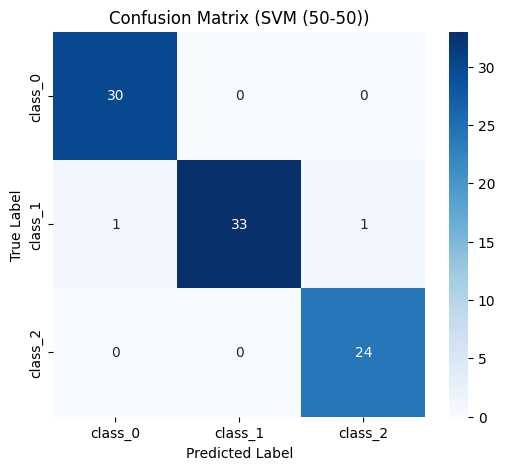


 Train-Test Split 60-40
Using best params for SVM: {'C': np.float64(1.0), 'degree': np.int64(3), 'gamma': 'auto', 'kernel': 'rbf'}

SVM (60-40) Results:
Accuracy=0.9861, Precision=0.9866, Recall=0.9861, F1=0.9860


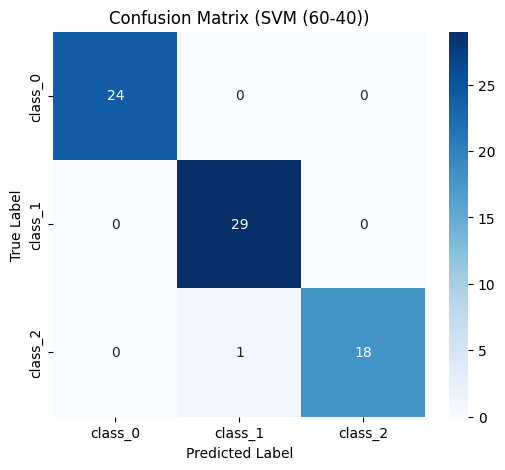


 Train-Test Split 70-30
Using best params for SVM: {'C': np.float64(1.0), 'degree': np.int64(2), 'gamma': 'scale', 'kernel': 'rbf'}

SVM (70-30) Results:
Accuracy=0.9815, Precision=0.9823, Recall=0.9815, F1=0.9814


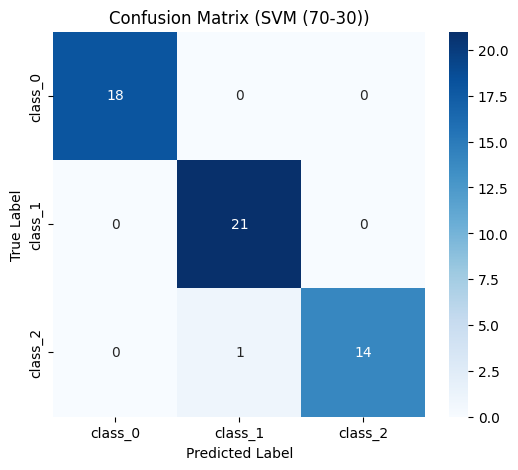


 Train-Test Split 80-20
Using best params for SVM: {'C': np.float64(10.0), 'degree': np.int64(3), 'gamma': 'auto', 'kernel': 'rbf'}

SVM (80-20) Results:
Accuracy=0.9444, Precision=0.9514, Recall=0.9444, F1=0.9432


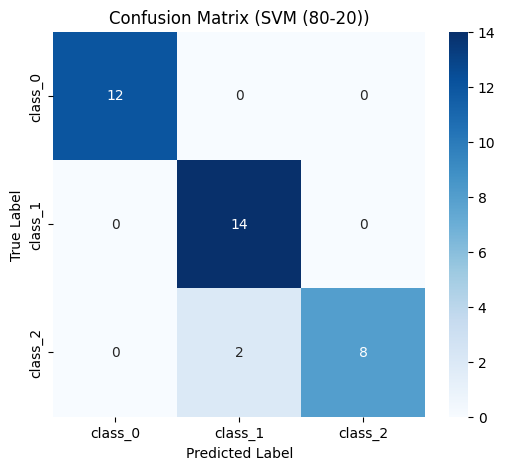

In [7]:
splits = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2)]
results_summary = []
roc_collector = {}

# Loop for SVM
for train_size, test_size in splits:
    split_label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n Train-Test Split {split_label}\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Halving Grid Search
    grid = HalvingGridSearchCV(
        svm_model, svm_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train, y_train)

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by="mean_test_score", ascending=False)

    top_acc = results.iloc[0]["mean_test_score"]
    if top_acc >= 1.0:
        valid_results = results[results["mean_test_score"] < 1.0]
    else:
        valid_results = results

    if not valid_results.empty:
        best_row = valid_results.iloc[0]
        best_params = {k.replace("param_", ""): best_row[k]
                       for k in results.columns if k.startswith("param_")}
        print(f"Using best params for SVM: {best_params}")

        best_model = SVC(**best_params, probability=True, random_state=42)

        acc, prec, rec, f1, roc_data = evaluate_model(
            best_model, X_train, X_test, y_train, y_test,
            model_name=f"SVM ({split_label})"
        )
        params_str = ", ".join(f"{k}={v}" for k, v in best_params.items())
        results_summary.append([split_label, acc, prec, rec, f1, params_str])


        if roc_data:
            roc_collector[split_label] = roc_data

    else:
        print(f"No valid SVM models under 1.0 accuracy for split {split_label}")


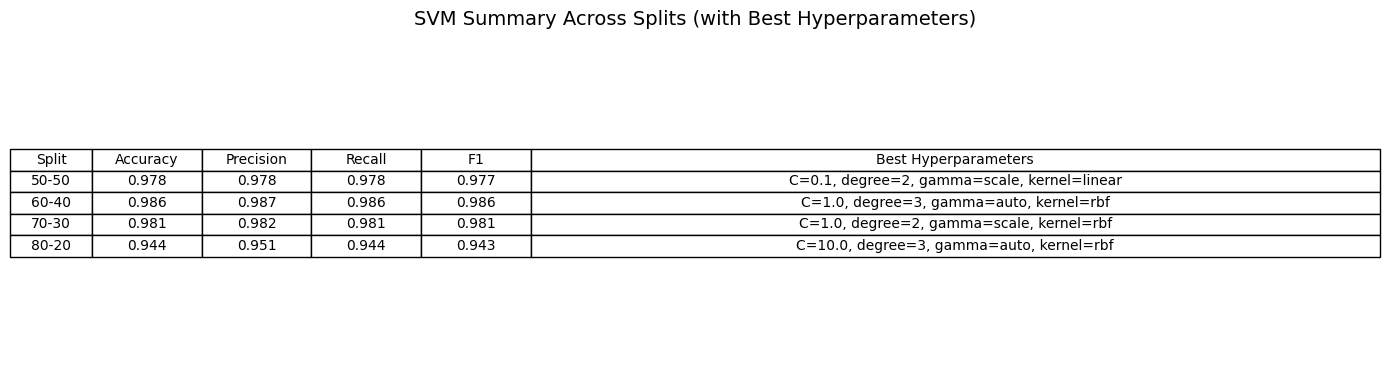

In [8]:
# Prepare DataFrame
summary_df = pd.DataFrame(results_summary,
                          columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df) * 0.7 + 1))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=summary_df.round(3).astype(str).values,
                 colLabels=summary_df.columns,
                 cellLoc='center',
                 loc='center')

# Disable automatic font sizing and set font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Scale table: horizontal scale is arbitrary, we will set col widths explicitly
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
# sum should be ~1.0 for proportion

# Adjust each column width by modifying cell widths in each row (including header)
for col_idx, width in enumerate(col_widths):
    # Header cell
    cell = table[0, col_idx]
    cell.set_width(width)
    # Data cells
    for row_idx in range(1, len(summary_df) + 1):
        cell = table[row_idx, col_idx]
        cell.set_width(width)

plt.title("SVM Summary Across Splits (with Best Hyperparameters)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

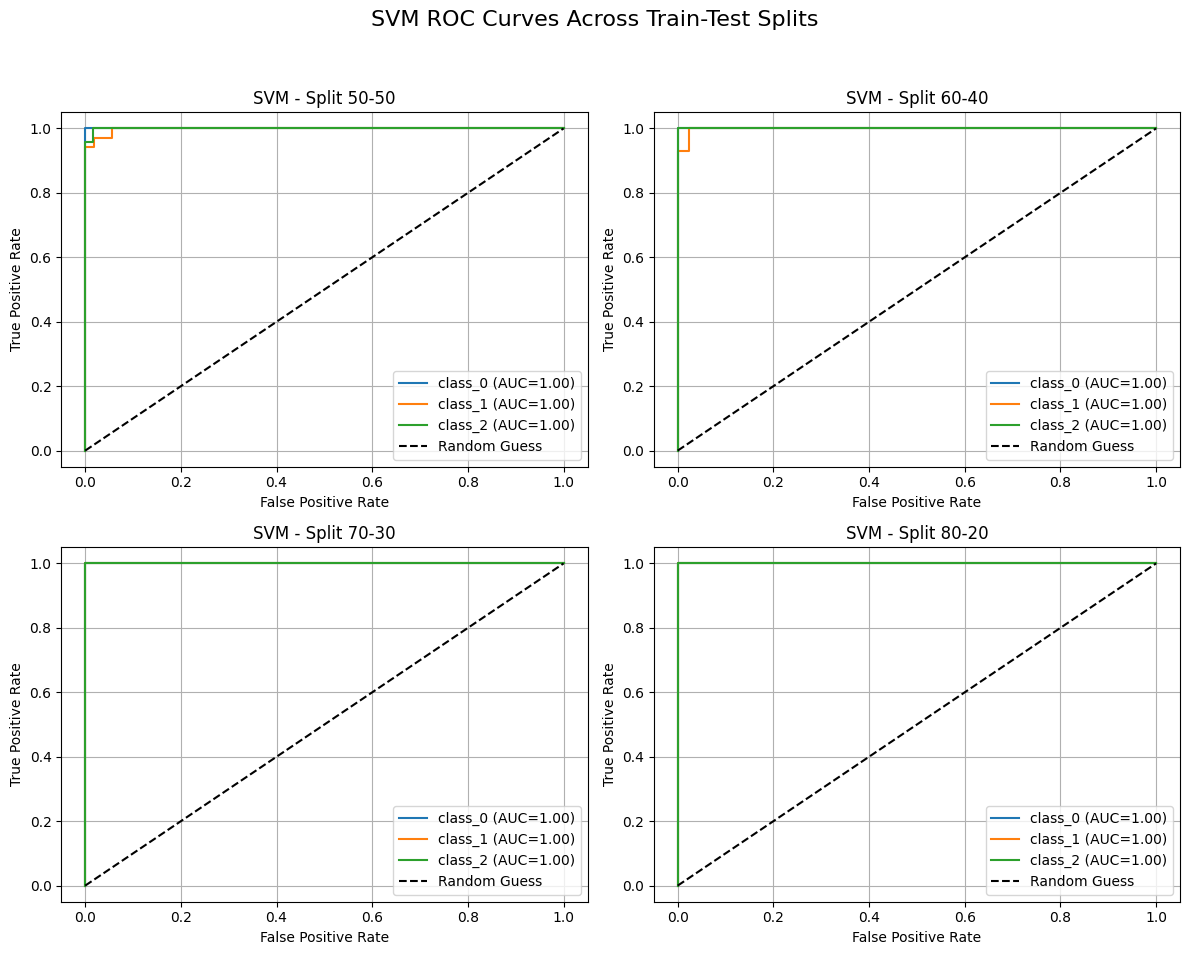

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, (split_label, (fpr, tpr, roc_auc)) in enumerate(roc_collector.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"SVM - Split {split_label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("SVM ROC Curves Across Train-Test Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#SVM with PCA


 Train-Test Split 50-50 with PCA
Using best params for SVM with PCA: {'C': np.float64(0.1), 'degree': np.int64(2), 'gamma': 'scale', 'kernel': 'linear'}

SVM PCA (50-50) Results:
Accuracy=0.9438, Precision=0.9474, Recall=0.9438, F1=0.9441


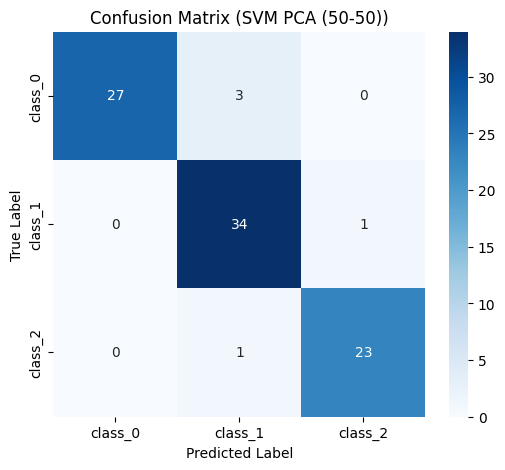


 Train-Test Split 60-40 with PCA
Using best params for SVM with PCA: {'C': np.float64(0.1), 'degree': np.int64(2), 'gamma': 'scale', 'kernel': 'linear'}

SVM PCA (60-40) Results:
Accuracy=0.9583, Precision=0.9622, Recall=0.9583, F1=0.9586


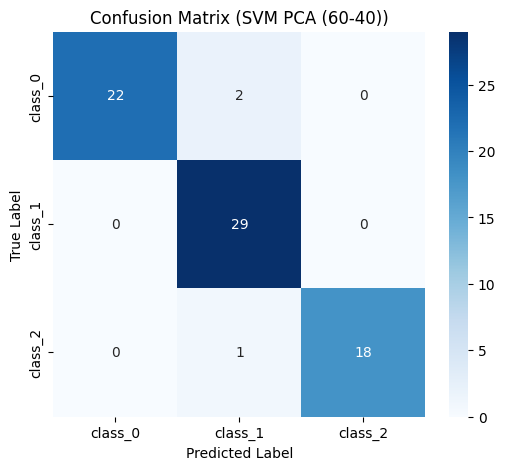


 Train-Test Split 70-30 with PCA
Using best params for SVM with PCA: {'C': np.float64(1.0), 'degree': np.int64(3), 'gamma': 'scale', 'kernel': 'linear'}

SVM PCA (70-30) Results:
Accuracy=0.9444, Precision=0.9477, Recall=0.9444, F1=0.9440


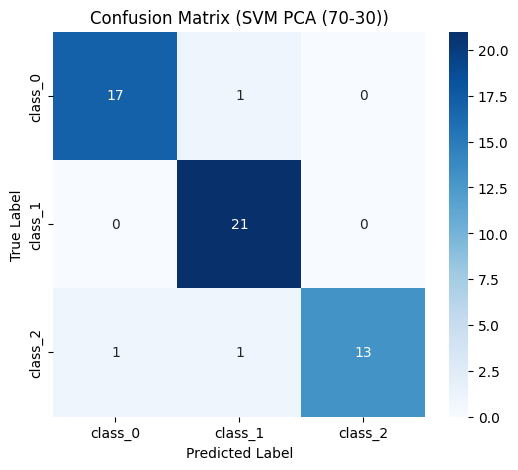


 Train-Test Split 80-20 with PCA
Using best params for SVM with PCA: {'C': np.float64(1.0), 'degree': np.int64(3), 'gamma': 'auto', 'kernel': 'linear'}

SVM PCA (80-20) Results:
Accuracy=0.9444, Precision=0.9484, Recall=0.9444, F1=0.9424


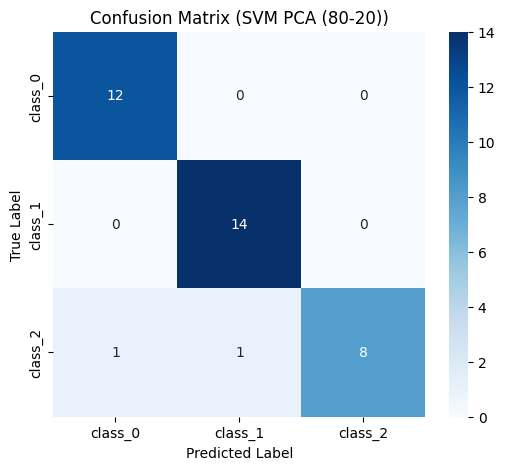

In [10]:
from sklearn.decomposition import PCA

# PCA with 5 components
pca = PCA(n_components=5)

splits = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2)]
results_summary_pca = []
roc_collector_pca = {}

for train_size, test_size in splits:
    split_label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n Train-Test Split {split_label} with PCA\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # PCA fit on train only!
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Standardize after PCA (optional but often useful)
    scaler = StandardScaler()
    X_train_pca = scaler.fit_transform(X_train_pca)
    X_test_pca = scaler.transform(X_test_pca)

    # Halving Grid Search on PCA-transformed data
    grid = HalvingGridSearchCV(
        svm_model, svm_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train_pca, y_train)

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by="mean_test_score", ascending=False)

    top_acc = results.iloc[0]["mean_test_score"]
    if top_acc >= 1.0:
        valid_results = results[results["mean_test_score"] < 1.0]
    else:
        valid_results = results

    if not valid_results.empty:
        best_row = valid_results.iloc[0]
        best_params = {k.replace("param_", ""): best_row[k]
                       for k in results.columns if k.startswith("param_")}
        print(f"Using best params for SVM with PCA: {best_params}")

        best_model = SVC(**best_params, probability=True, random_state=42)

        acc, prec, rec, f1, roc_data = evaluate_model(
            best_model, X_train_pca, X_test_pca, y_train, y_test,
            model_name=f"SVM PCA ({split_label})"
        )
        params_str = ", ".join(f"{k}={v}" for k, v in best_params.items())
        results_summary_pca.append([split_label, acc, prec, rec, f1, params_str])

        if roc_data:
            roc_collector_pca[split_label] = roc_data

    else:
        print(f"No valid SVM models under 1.0 accuracy for split {split_label} with PCA")


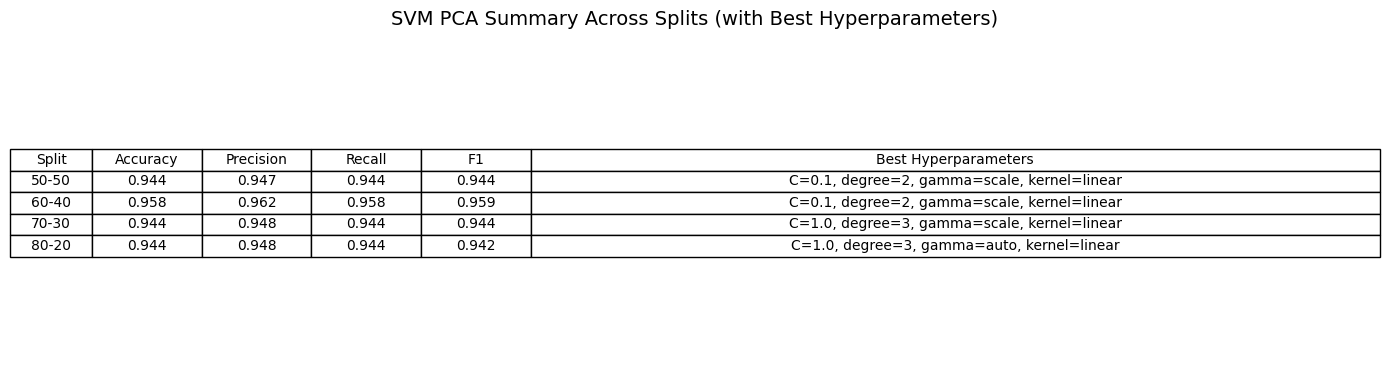

In [11]:
# Summary Table for PCA
summary_df_pca = pd.DataFrame(results_summary_pca,
                              columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df_pca) * 0.7 + 1))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df_pca.round(3).astype(str).values,
                 colLabels=summary_df_pca.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]  # same as before

for col_idx, width in enumerate(col_widths):
    cell = table[0, col_idx]
    cell.set_width(width)
    for row_idx in range(1, len(summary_df_pca) + 1):
        cell = table[row_idx, col_idx]
        cell.set_width(width)

plt.title("SVM PCA Summary Across Splits (with Best Hyperparameters)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

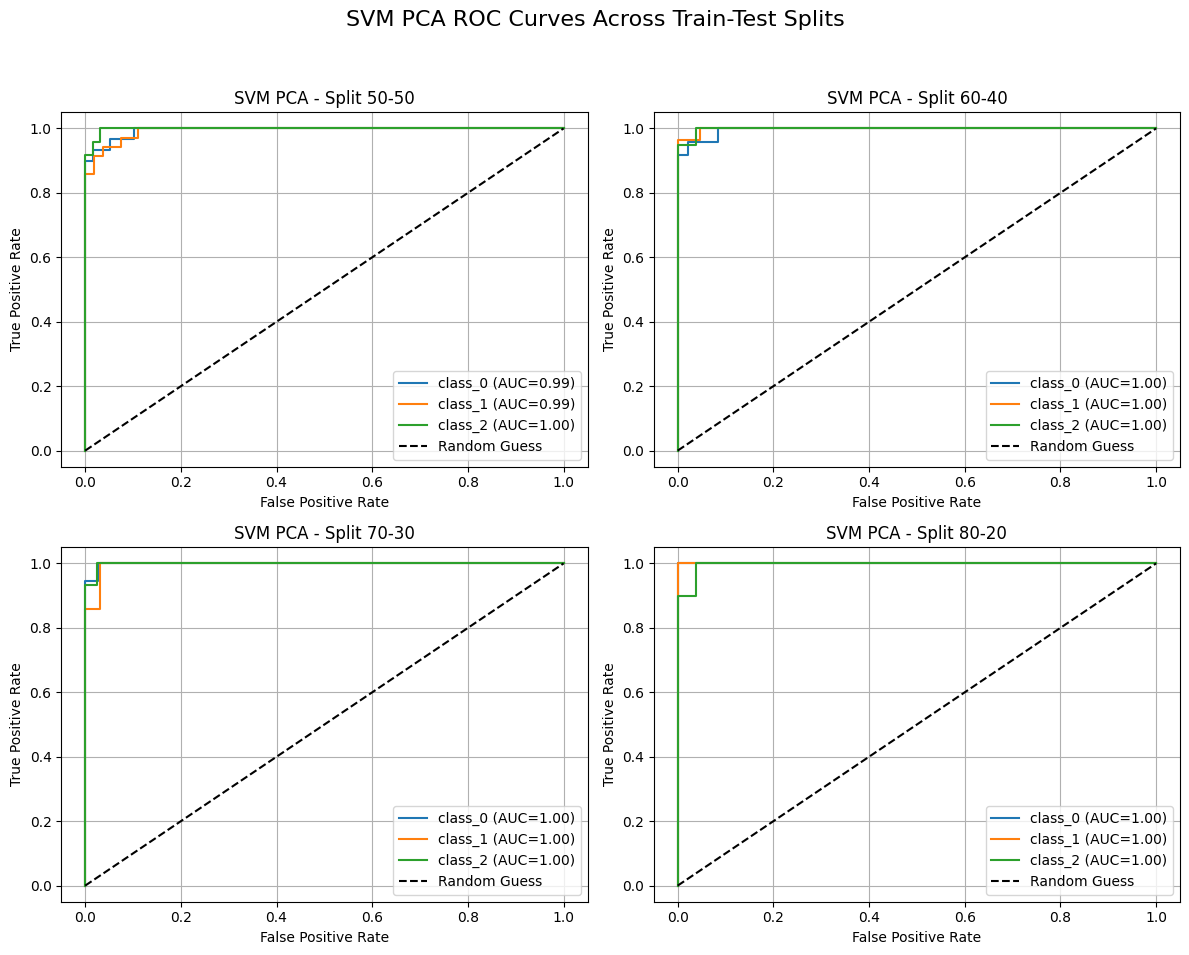

In [12]:
# ROC curves for PCA runs
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, (split_label, (fpr, tpr, roc_auc)) in enumerate(roc_collector_pca.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"SVM PCA - Split {split_label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("SVM PCA ROC Curves Across Train-Test Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(random_state=42, max_iter=1000)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
    'learning_rate': ['constant', 'adaptive']
}


 Train-Test Split 50-50 (MLP)
Using best params for MLP: {'activation': 'relu', 'alpha': np.float64(0.0001), 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}

MLP (50-50) Results:
Accuracy=0.9551, Precision=0.9558, Recall=0.9551, F1=0.9548


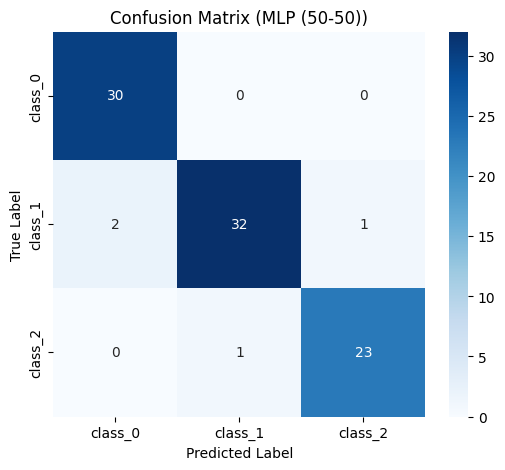


 Train-Test Split 60-40 (MLP)
Using best params for MLP: {'activation': 'tanh', 'alpha': np.float64(0.01), 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

MLP (60-40) Results:
Accuracy=0.9861, Precision=0.9867, Recall=0.9861, F1=0.9861


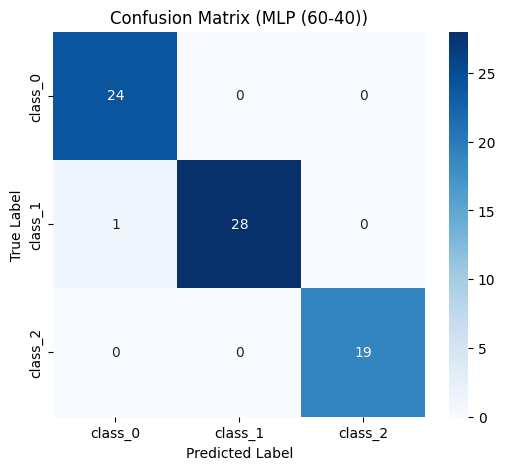


 Train-Test Split 70-30 (MLP)
Using best params for MLP: {'activation': 'tanh', 'alpha': np.float64(0.01), 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive'}

MLP (70-30) Results:
Accuracy=0.9815, Precision=0.9826, Recall=0.9815, F1=0.9816


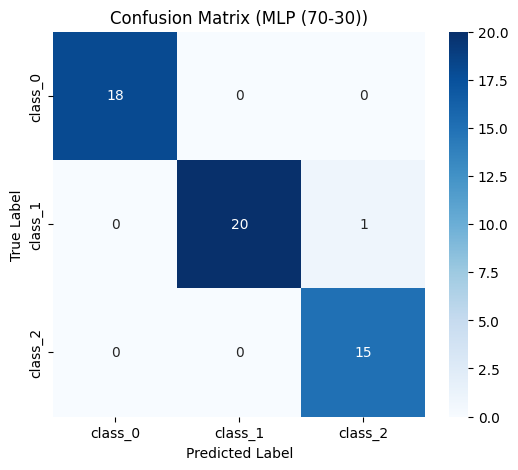


 Train-Test Split 80-20 (MLP)
Using best params for MLP: {'activation': 'tanh', 'alpha': np.float64(0.01), 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

MLP (80-20) Results:
Accuracy=0.9722, Precision=0.9741, Recall=0.9722, F1=0.9720


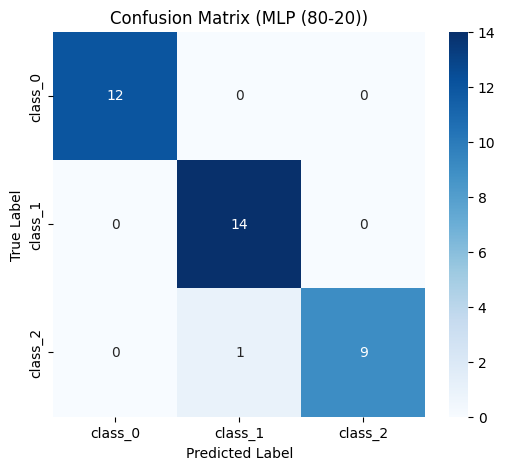

In [14]:
results_summary_mlp = []
roc_collector_mlp = {}

for train_size, test_size in splits:
    split_label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n Train-Test Split {split_label} (MLP)\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Halving Grid Search for MLP
    grid = HalvingGridSearchCV(
        mlp_model, mlp_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train, y_train)

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by="mean_test_score", ascending=False)

    top_acc = results.iloc[0]["mean_test_score"]
    if top_acc >= 1.0:
        valid_results = results[results["mean_test_score"] < 1.0]
    else:
        valid_results = results

    if not valid_results.empty:
        best_row = valid_results.iloc[0]
        best_params = {k.replace("param_", ""): best_row[k]
                       for k in results.columns if k.startswith("param_")}
        print(f"Using best params for MLP: {best_params}")

        best_model = MLPClassifier(**best_params, random_state=42, max_iter=1000)

        acc, prec, rec, f1, roc_data = evaluate_model(
            best_model, X_train, X_test, y_train, y_test,
            model_name=f"MLP ({split_label})"
        )
        params_str = ", ".join(f"{k}={v}" for k, v in best_params.items())
        results_summary_mlp.append([split_label, acc, prec, rec, f1, params_str])

        if roc_data:
            roc_collector_mlp[split_label] = roc_data

    else:
        print(f"No valid MLP models under 1.0 accuracy for split {split_label}")


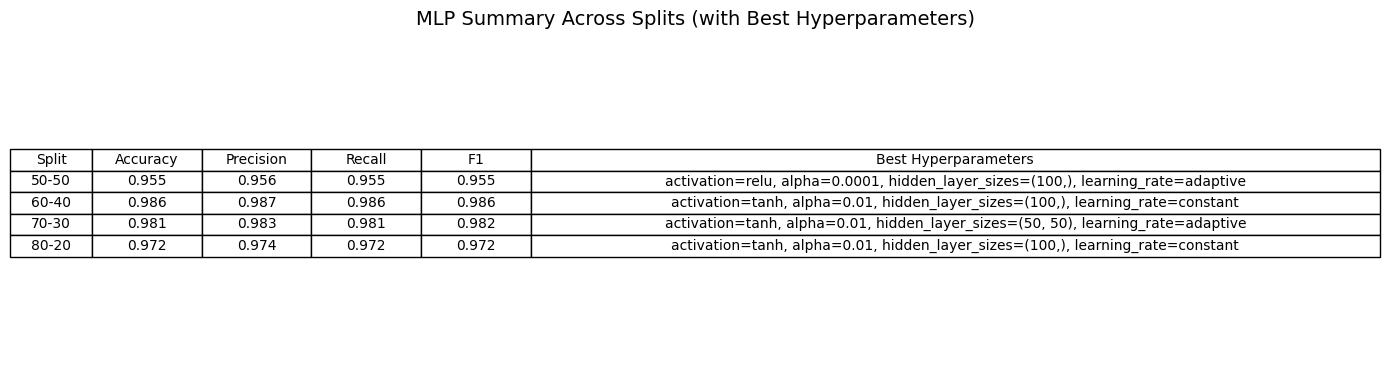

In [15]:
summary_df_mlp = pd.DataFrame(results_summary_mlp,
                              columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df_mlp) * 0.7 + 1))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df_mlp.round(3).astype(str).values,
                 colLabels=summary_df_mlp.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]

for col_idx, width in enumerate(col_widths):
    cell = table[0, col_idx]
    cell.set_width(width)
    for row_idx in range(1, len(summary_df_mlp) + 1):
        cell = table[row_idx, col_idx]
        cell.set_width(width)

plt.title("MLP Summary Across Splits (with Best Hyperparameters)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

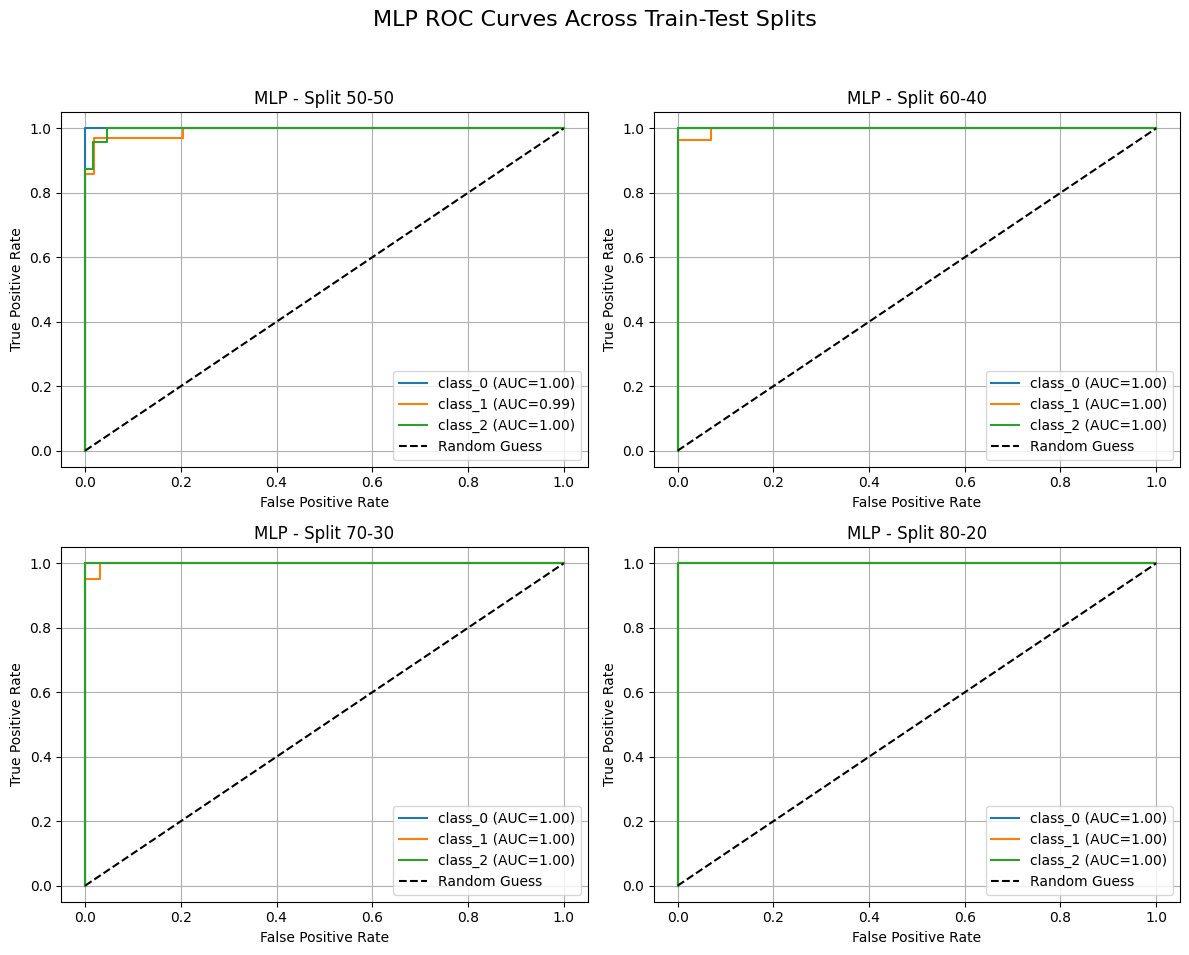

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, (split_label, (fpr, tpr, roc_auc)) in enumerate(roc_collector_mlp.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"MLP - Split {split_label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("MLP ROC Curves Across Train-Test Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


 Train-Test Split 50-50 (MLP + PCA)
Using best params for MLP + PCA: {'activation': 'relu', 'alpha': np.float64(0.0001), 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

MLP + PCA (50-50) Results:
Accuracy=0.9438, Precision=0.9435, Recall=0.9438, F1=0.9435


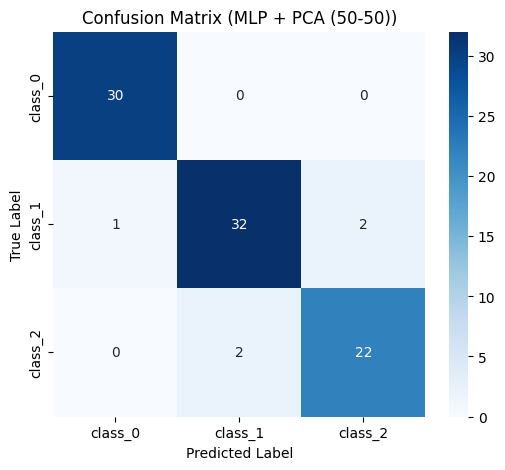


 Train-Test Split 60-40 (MLP + PCA)
Using best params for MLP + PCA: {'activation': 'tanh', 'alpha': np.float64(0.001), 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}

MLP + PCA (60-40) Results:
Accuracy=0.9583, Precision=0.9600, Recall=0.9583, F1=0.9583


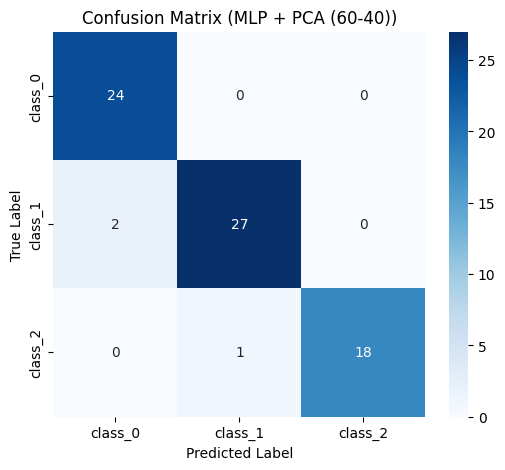


 Train-Test Split 70-30 (MLP + PCA)
Using best params for MLP + PCA: {'activation': 'relu', 'alpha': np.float64(0.0001), 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

MLP + PCA (70-30) Results:
Accuracy=0.9630, Precision=0.9662, Recall=0.9630, F1=0.9625


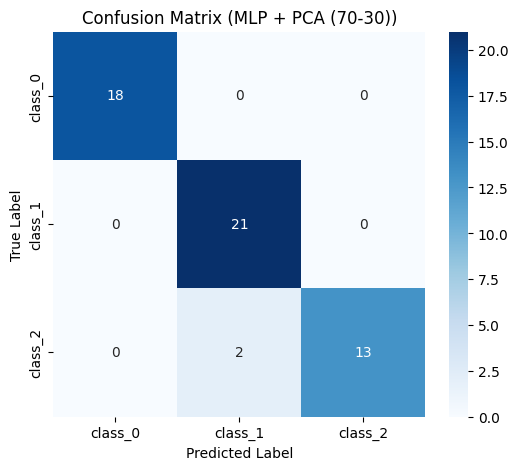


 Train-Test Split 80-20 (MLP + PCA)
Using best params for MLP + PCA: {'activation': 'relu', 'alpha': np.float64(0.0001), 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

MLP + PCA (80-20) Results:
Accuracy=0.9444, Precision=0.9514, Recall=0.9444, F1=0.9432


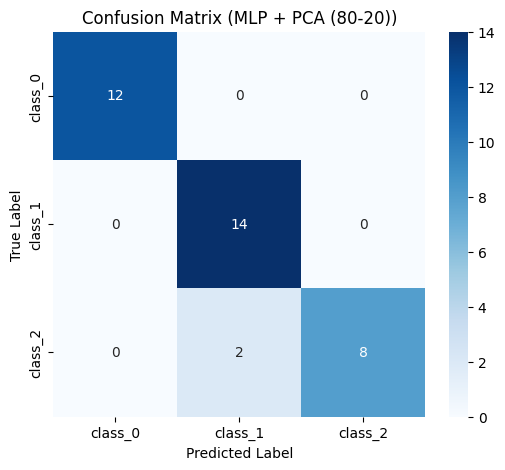

In [17]:
results_summary_mlp_pca = []
roc_collector_mlp_pca = {}

for train_size, test_size in splits:
    split_label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n Train-Test Split {split_label} (MLP + PCA)\n{'='*50}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # PCA transform
    pca = PCA(n_components=7, random_state=42)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # HalvingGridSearch for MLP with PCA data
    grid = HalvingGridSearchCV(
        mlp_model, mlp_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train, y_train)

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by="mean_test_score", ascending=False)

    top_acc = results.iloc[0]["mean_test_score"]
    if top_acc >= 1.0:
        valid_results = results[results["mean_test_score"] < 1.0]
    else:
        valid_results = results

    if not valid_results.empty:
        best_row = valid_results.iloc[0]
        best_params = {k.replace("param_", ""): best_row[k]
                       for k in results.columns if k.startswith("param_")}
        print(f"Using best params for MLP + PCA: {best_params}")

        best_model = MLPClassifier(**best_params, random_state=42, max_iter=1000)

        acc, prec, rec, f1, roc_data = evaluate_model(
            best_model, X_train, X_test, y_train, y_test,
            model_name=f"MLP + PCA ({split_label})"
        )
        params_str = ", ".join(f"{k}={v}" for k, v in best_params.items())
        results_summary_mlp_pca.append([split_label, acc, prec, rec, f1, params_str])

        if roc_data:
            roc_collector_mlp_pca[split_label] = roc_data

    else:
        print(f"No valid MLP models under 1.0 accuracy for split {split_label}")

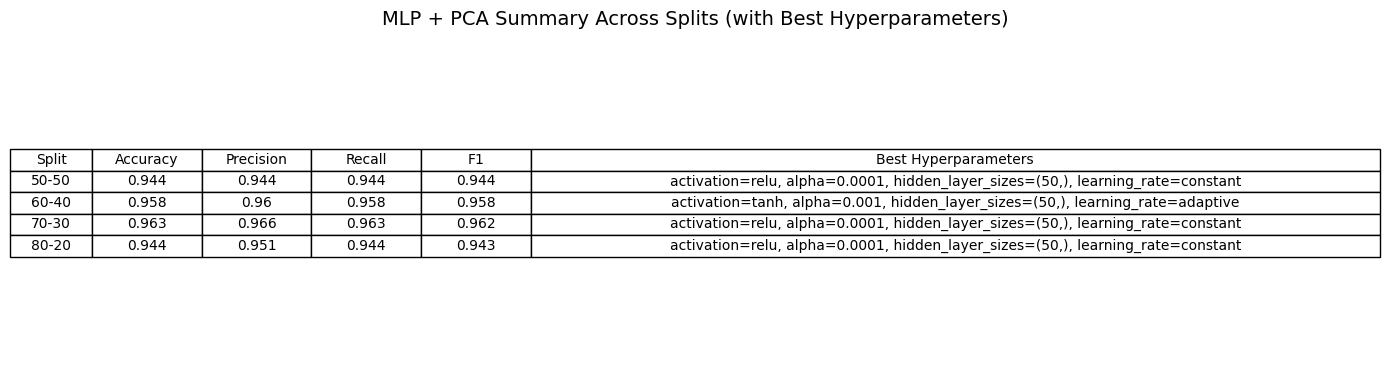

In [19]:
# Prepare DataFrame and plot summary table
summary_df_mlp_pca = pd.DataFrame(results_summary_mlp_pca,
                                  columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df_mlp_pca) * 0.7 + 1))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df_mlp_pca.round(3).astype(str).values,
                 colLabels=summary_df_mlp_pca.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]

for col_idx, width in enumerate(col_widths):
    cell = table[0, col_idx]
    cell.set_width(width)
    for row_idx in range(1, len(summary_df_mlp_pca) + 1):
        cell = table[row_idx, col_idx]
        cell.set_width(width)

plt.title("MLP + PCA Summary Across Splits (with Best Hyperparameters)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

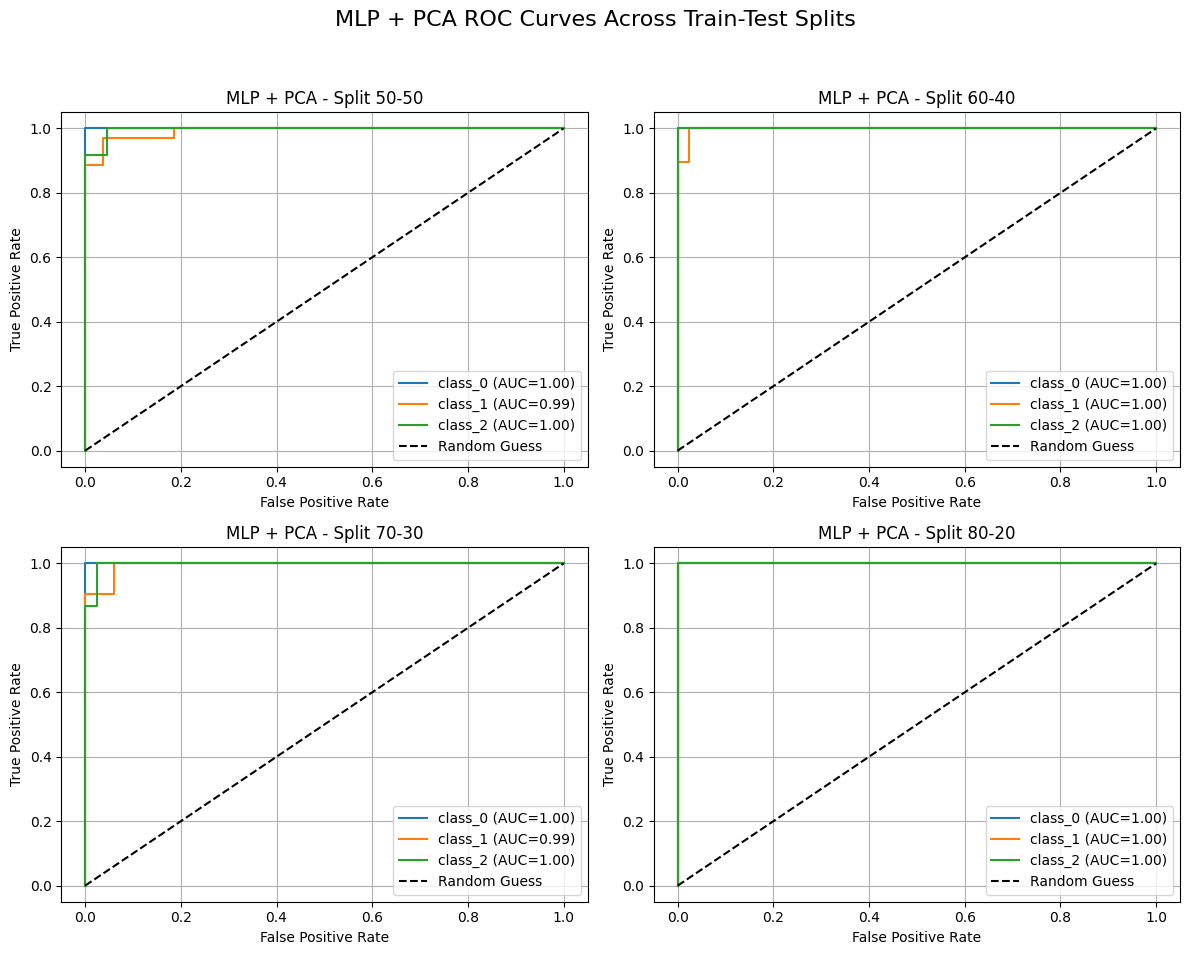

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, (split_label, (fpr, tpr, roc_auc)) in enumerate(roc_collector_mlp_pca.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"MLP + PCA - Split {split_label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("MLP + PCA ROC Curves Across Train-Test Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model and params
rf_model = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [10, 15, 30],
    'max_depth': [None, 2, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}


 Train-Test Split 50-50 (Random Forest)
Using best params for RF: {'max_depth': None, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(10)}

Random Forest (50-50) Results:
Accuracy=0.9663, Precision=0.9663, Recall=0.9663, F1=0.9661


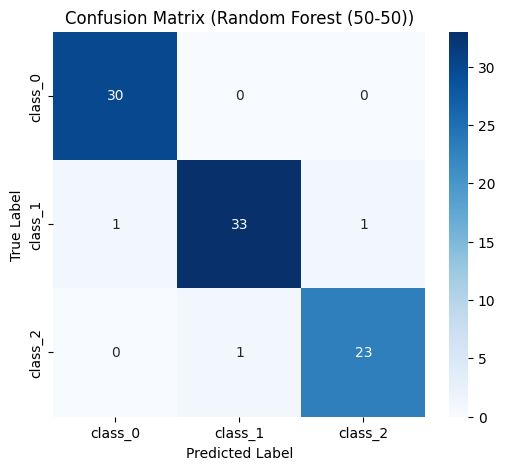


 Train-Test Split 60-40 (Random Forest)
Using best params for RF: {'max_depth': 5, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(30)}

Random Forest (60-40) Results:
Accuracy=0.9722, Precision=0.9735, Recall=0.9722, F1=0.9720


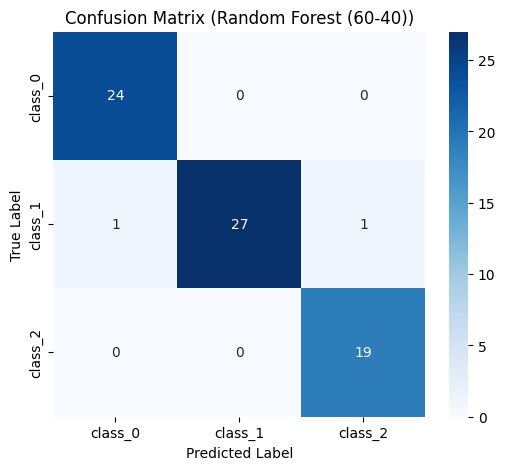


 Train-Test Split 70-30 (Random Forest)
Using best params for RF: {'max_depth': None, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(15)}

Random Forest (70-30) Results:
Accuracy=0.9815, Precision=0.9823, Recall=0.9815, F1=0.9814


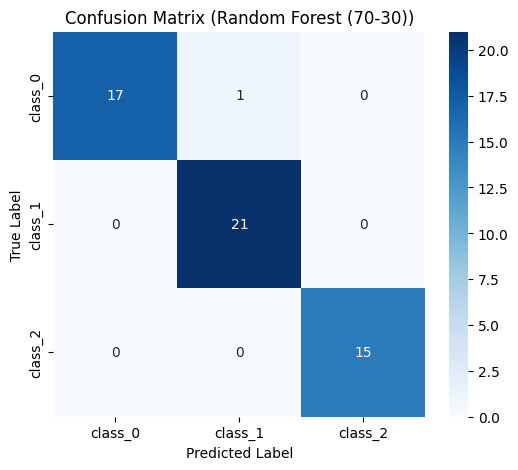


 Train-Test Split 80-20 (Random Forest)
Using best params for RF: {'max_depth': 5, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(3), 'n_estimators': np.int64(30)}

Random Forest (80-20) Results:
Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000


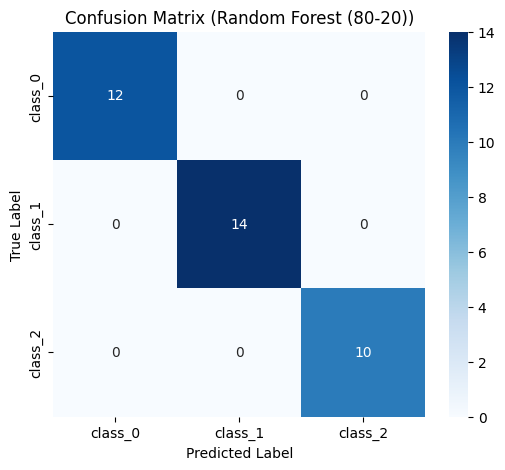

In [32]:
splits = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2)]
results_summary_rf = []
roc_collector_rf = {}

for train_size, test_size in splits:
    split_label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n Train-Test Split {split_label} (Random Forest)\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize features (optional for RF, but for consistency)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    grid = HalvingGridSearchCV(
        rf_model, rf_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train, y_train)

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by="mean_test_score", ascending=False)

    top_acc = results.iloc[0]["mean_test_score"]
    if top_acc >= 1.0:
        valid_results = results[results["mean_test_score"] < 1.0]
    else:
        valid_results = results

    if not valid_results.empty:
        best_row = valid_results.iloc[0]
        best_params = {k.replace("param_", ""): best_row[k]
                       for k in results.columns if k.startswith("param_")}
        print(f"Using best params for RF: {best_params}")

        best_model = RandomForestClassifier(**best_params, random_state=42)

        acc, prec, rec, f1, roc_data = evaluate_model(
            best_model, X_train, X_test, y_train, y_test,
            model_name=f"Random Forest ({split_label})"
        )
        params_str = ", ".join(f"{k}={v}" for k, v in best_params.items())
        results_summary_rf.append([split_label, acc, prec, rec, f1, params_str])

        if roc_data:
            roc_collector_rf[split_label] = roc_data

    else:
        print(f"No valid RF models under 1.0 accuracy for split {split_label}")

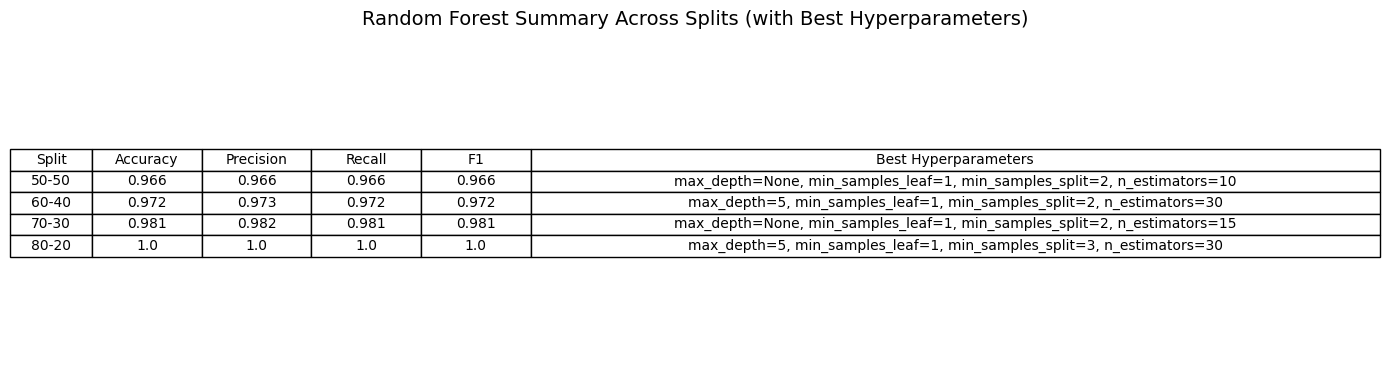

In [33]:
# Prepare summary table
summary_df_rf = pd.DataFrame(results_summary_rf,
                             columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df_rf) * 0.7 + 1))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df_rf.round(3).astype(str).values,
                 colLabels=summary_df_rf.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for col_idx, width in enumerate(col_widths):
    cell = table[0, col_idx]
    cell.set_width(width)
    for row_idx in range(1, len(summary_df_rf) + 1):
        cell = table[row_idx, col_idx]
        cell.set_width(width)

plt.title("Random Forest Summary Across Splits (with Best Hyperparameters)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

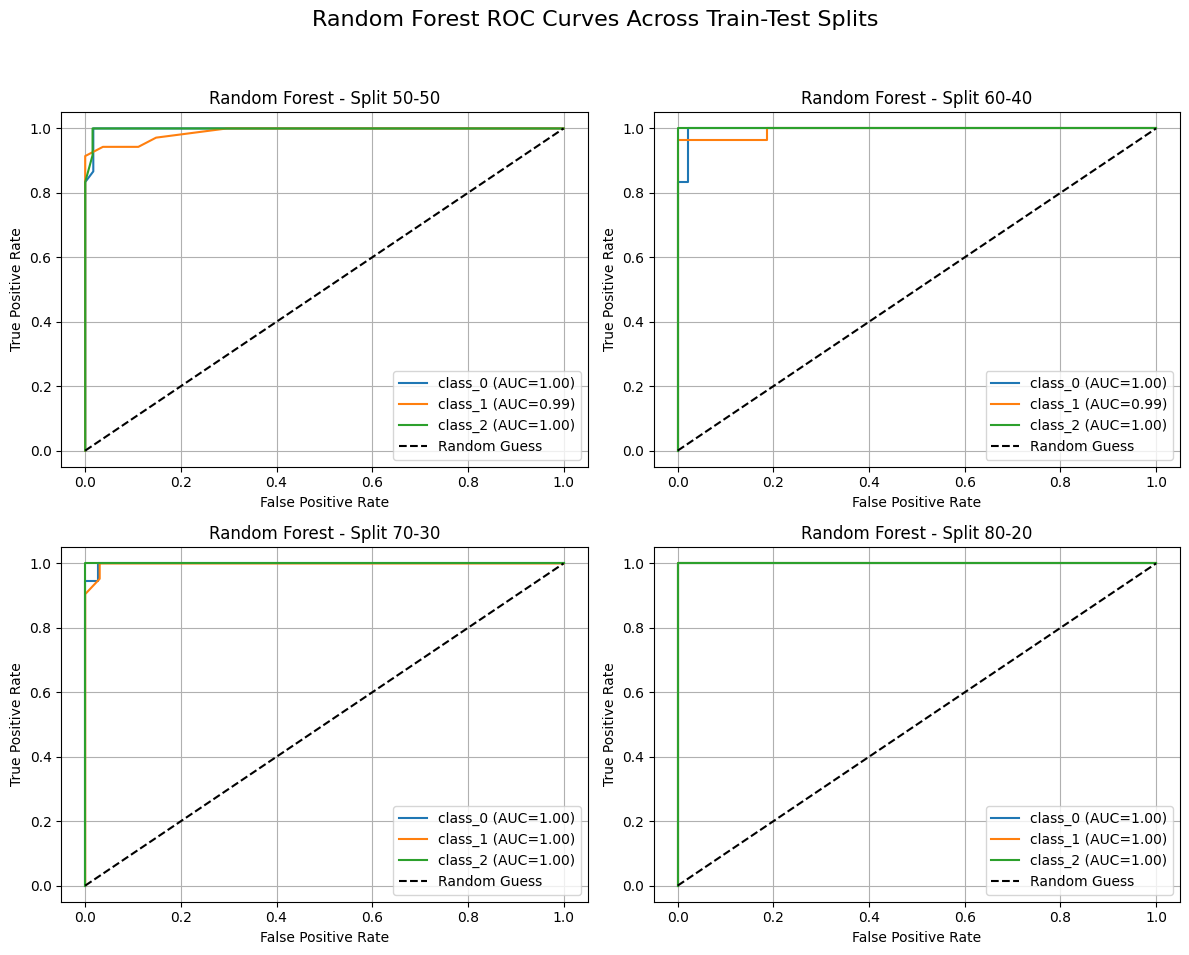

In [34]:
# ROC curves plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, (split_label, (fpr, tpr, roc_auc)) in enumerate(roc_collector_rf.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"Random Forest - Split {split_label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("Random Forest ROC Curves Across Train-Test Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [35]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}


 Train-Test Split 50-50 (Random Forest + PCA=5)
Using best params for RF: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(50)}

Random Forest + PCA=5 (50-50) Results:
Accuracy=0.8764, Precision=0.8775, Recall=0.8764, F1=0.8768


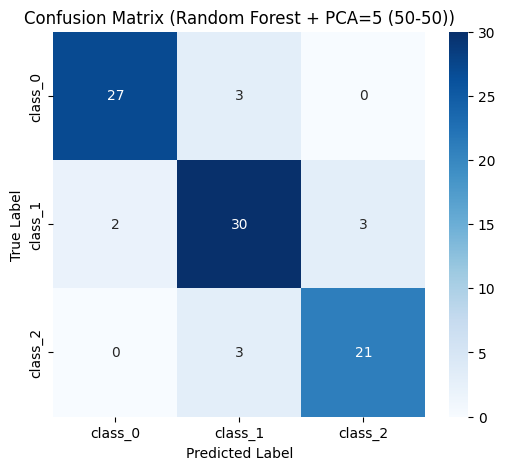


 Train-Test Split 60-40 (Random Forest + PCA=5)
Using best params for RF: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(50)}

Random Forest + PCA=5 (60-40) Results:
Accuracy=0.9167, Precision=0.9203, Recall=0.9167, F1=0.9173


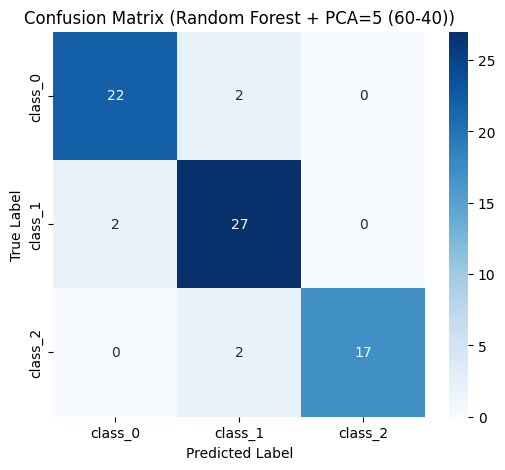


 Train-Test Split 70-30 (Random Forest + PCA=5)
Using best params for RF: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(5), 'n_estimators': np.int64(100)}

Random Forest + PCA=5 (70-30) Results:
Accuracy=0.9630, Precision=0.9630, Recall=0.9630, F1=0.9630


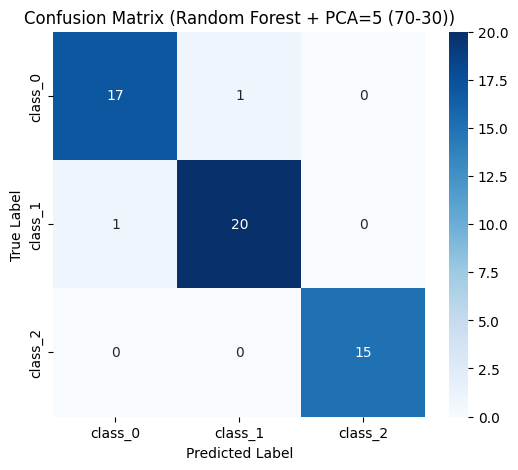


 Train-Test Split 80-20 (Random Forest + PCA=5)
Using best params for RF: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(50)}

Random Forest + PCA=5 (80-20) Results:
Accuracy=0.9444, Precision=0.9444, Recall=0.9444, F1=0.9444


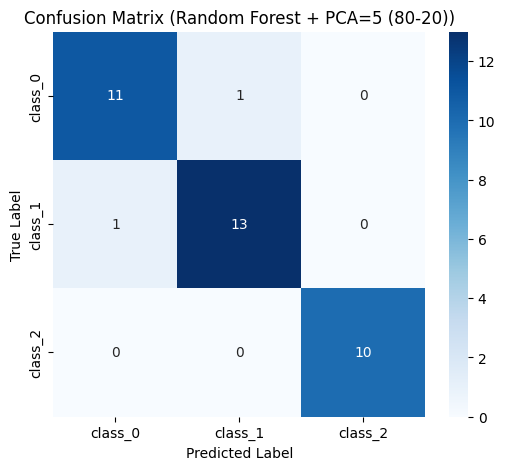

In [36]:
splits = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2)]
results_summary_rf = []
roc_collector_rf = {}

for train_size, test_size in splits:
    split_label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n Train-Test Split {split_label} (Random Forest + PCA=5)\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA with 5 components
    pca = PCA(n_components=5, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Hyperparameter tuning with HalvingGridSearchCV on PCA-transformed data
    grid = HalvingGridSearchCV(
        rf_model, rf_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train_pca, y_train)

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by="mean_test_score", ascending=False)

    top_acc = results.iloc[0]["mean_test_score"]
    if top_acc >= 1.0:
        valid_results = results[results["mean_test_score"] < 1.0]
    else:
        valid_results = results

    if not valid_results.empty:
        best_row = valid_results.iloc[0]
        best_params = {k.replace("param_", ""): best_row[k]
                       for k in results.columns if k.startswith("param_")}
        print(f"Using best params for RF: {best_params}")

        best_model = RandomForestClassifier(**best_params, random_state=42)

        acc, prec, rec, f1, roc_data = evaluate_model(
            best_model, X_train_pca, X_test_pca, y_train, y_test,
            model_name=f"Random Forest + PCA=5 ({split_label})"
        )
        params_str = ", ".join(f"{k}={v}" for k, v in best_params.items())
        results_summary_rf.append([split_label, acc, prec, rec, f1, params_str])

        if roc_data:
            roc_collector_rf[split_label] = roc_data

    else:
        print(f"No valid RF models under 1.0 accuracy for split {split_label}")

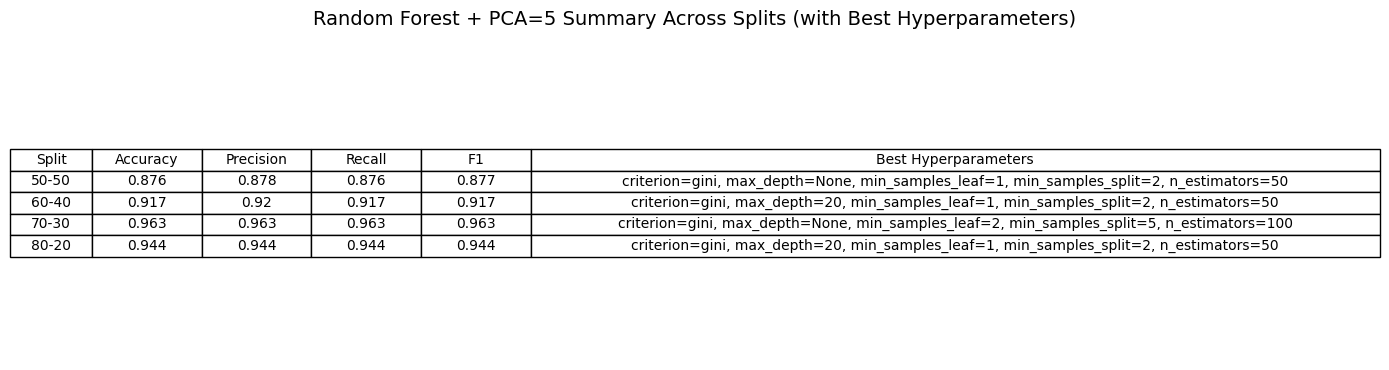

In [37]:
# Prepare summary table
summary_df_rf = pd.DataFrame(results_summary_rf,
                             columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df_rf) * 0.7 + 1))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df_rf.round(3).astype(str).values,
                 colLabels=summary_df_rf.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for col_idx, width in enumerate(col_widths):
    cell = table[0, col_idx]
    cell.set_width(width)
    for row_idx in range(1, len(summary_df_rf) + 1):
        cell = table[row_idx, col_idx]
        cell.set_width(width)

plt.title("Random Forest + PCA=5 Summary Across Splits (with Best Hyperparameters)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

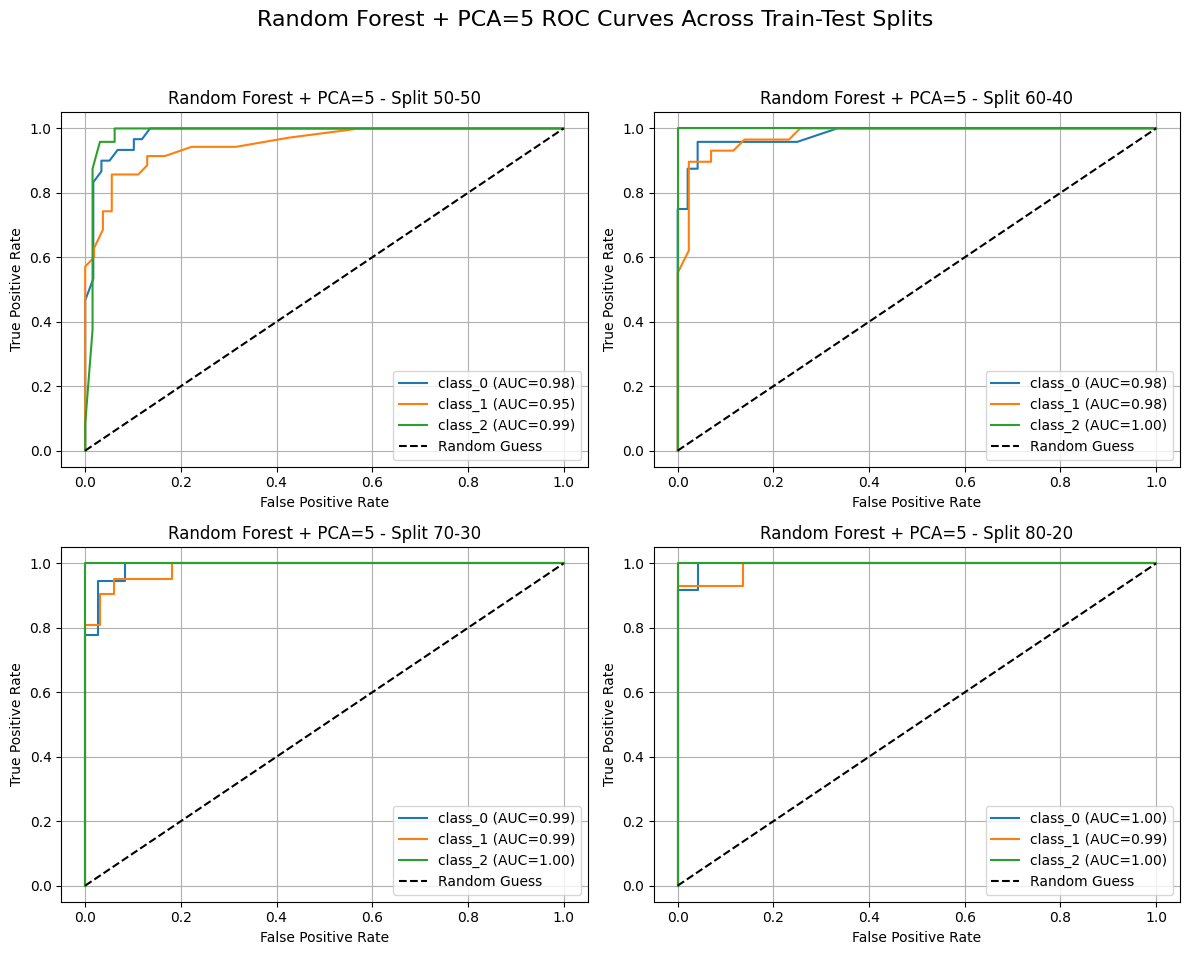

In [38]:
# ROC curves plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, (split_label, (fpr, tpr, roc_auc)) in enumerate(roc_collector_rf.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"Random Forest + PCA=5 - Split {split_label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("Random Forest + PCA=5 ROC Curves Across Train-Test Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Digits SVM without PCA


In [39]:
from sklearn.datasets import load_digits

# Load Digits dataset
digits = load_digits()
X = digits.data
y = digits.target
classes = digits.target_names
print(classes)


[0 1 2 3 4 5 6 7 8 9]


In [40]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    print(f"\n{model_name} Results:")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    roc_data = None
    if hasattr(model, "predict_proba"):
        y_bin = label_binarize(y_test, classes=np.arange(len(classes)))
        y_score = model.predict_proba(X_test)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        roc_data = (fpr, tpr, roc_auc)

    return acc, prec, rec, f1, roc_data

In [41]:
# SVM and hyperparameters to tune
svm = SVC(probability=True, random_state=42)
svm_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10],
    "degree": [2, 3],
    "gamma": ["scale", "auto"]
}


 SVM on Digits — Split 50-50
Best params: {'C': np.float64(0.1), 'degree': np.int64(3), 'gamma': 'auto', 'kernel': 'linear'}

SVM Digits (50-50) Results:
Accuracy=0.9711, Precision=0.9717, Recall=0.9711, F1=0.9710


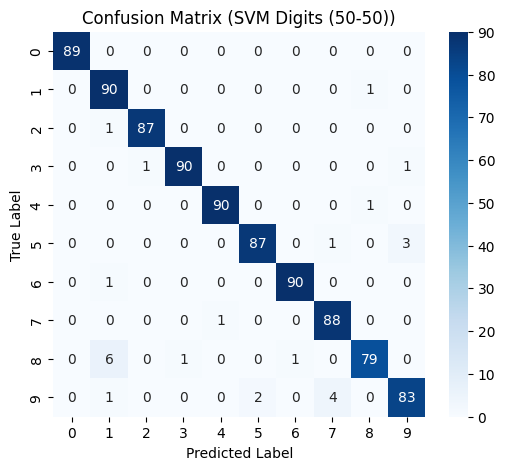


 SVM on Digits — Split 60-40
Best params: {'C': np.float64(10.0), 'degree': np.int64(3), 'gamma': 'scale', 'kernel': 'linear'}

SVM Digits (60-40) Results:
Accuracy=0.9708, Precision=0.9721, Recall=0.9708, F1=0.9709


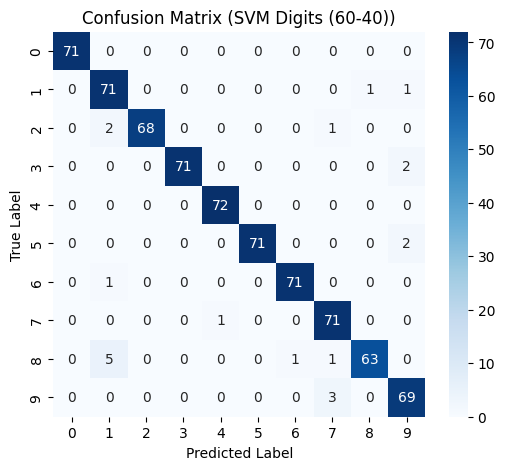


 SVM on Digits — Split 70-30
Best params: {'C': np.float64(0.1), 'degree': np.int64(3), 'gamma': 'scale', 'kernel': 'linear'}

SVM Digits (70-30) Results:
Accuracy=0.9796, Precision=0.9806, Recall=0.9796, F1=0.9795


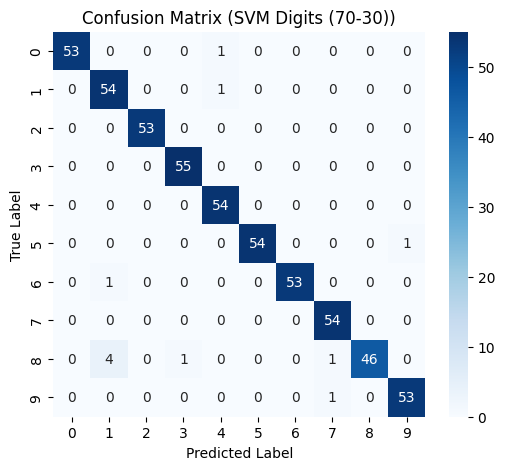


 SVM on Digits — Split 80-20
Best params: {'C': np.float64(10.0), 'degree': np.int64(2), 'gamma': 'auto', 'kernel': 'rbf'}

SVM Digits (80-20) Results:
Accuracy=0.9806, Precision=0.9810, Recall=0.9806, F1=0.9805


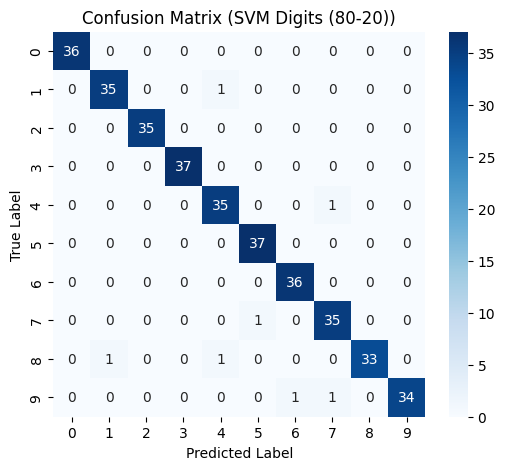

In [42]:
splits = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2)]
results_summary = []
roc_collector = {}

for train_size, test_size in splits:
    label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n SVM on Digits — Split {label}\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    grid = HalvingGridSearchCV(svm, svm_params, cv=5, scoring="accuracy",
                               n_jobs=-1, random_state=42, verbose=0)
    grid.fit(X_train, y_train)

    df = pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)
    best = df[df["mean_test_score"] < 1.0].iloc[0] if df.iloc[0]["mean_test_score"] >= 1.0 else df.iloc[0]
    best_params = {k.replace("param_", ""): best[k] for k in df.columns if k.startswith("param_")}
    print(f"Best params: {best_params}")

    best_model = SVC(**best_params, probability=True, random_state=42)
    acc, prec, rec, f1, roc_data = evaluate_model(
        best_model, X_train, X_test, y_train, y_test,
        model_name=f"SVM Digits ({label})"
    )

    results_summary.append([label, acc, prec, rec, f1, ", ".join(f"{k}={v}" for k, v in best_params.items())])
    if roc_data:
        roc_collector[label] = roc_data

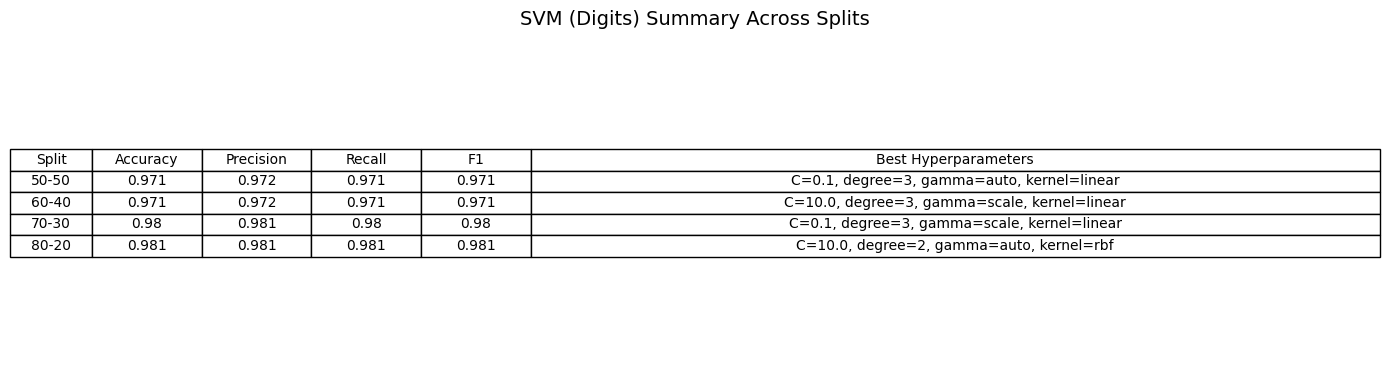

In [ ]:
# Summary table
summary_df = pd.DataFrame(results_summary,
                          columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df)*0.7 + 1))
ax.axis("tight"); ax.axis("off")
table = ax.table(cellText=summary_df.round(3).astype(str).values,
                 colLabels=summary_df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for i, w in enumerate(col_widths):
    table[0, i].set_width(w)
    for j in range(1, len(summary_df)+1):
        table[j, i].set_width(w)

plt.title("SVM (Digits) Summary Across Splits", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

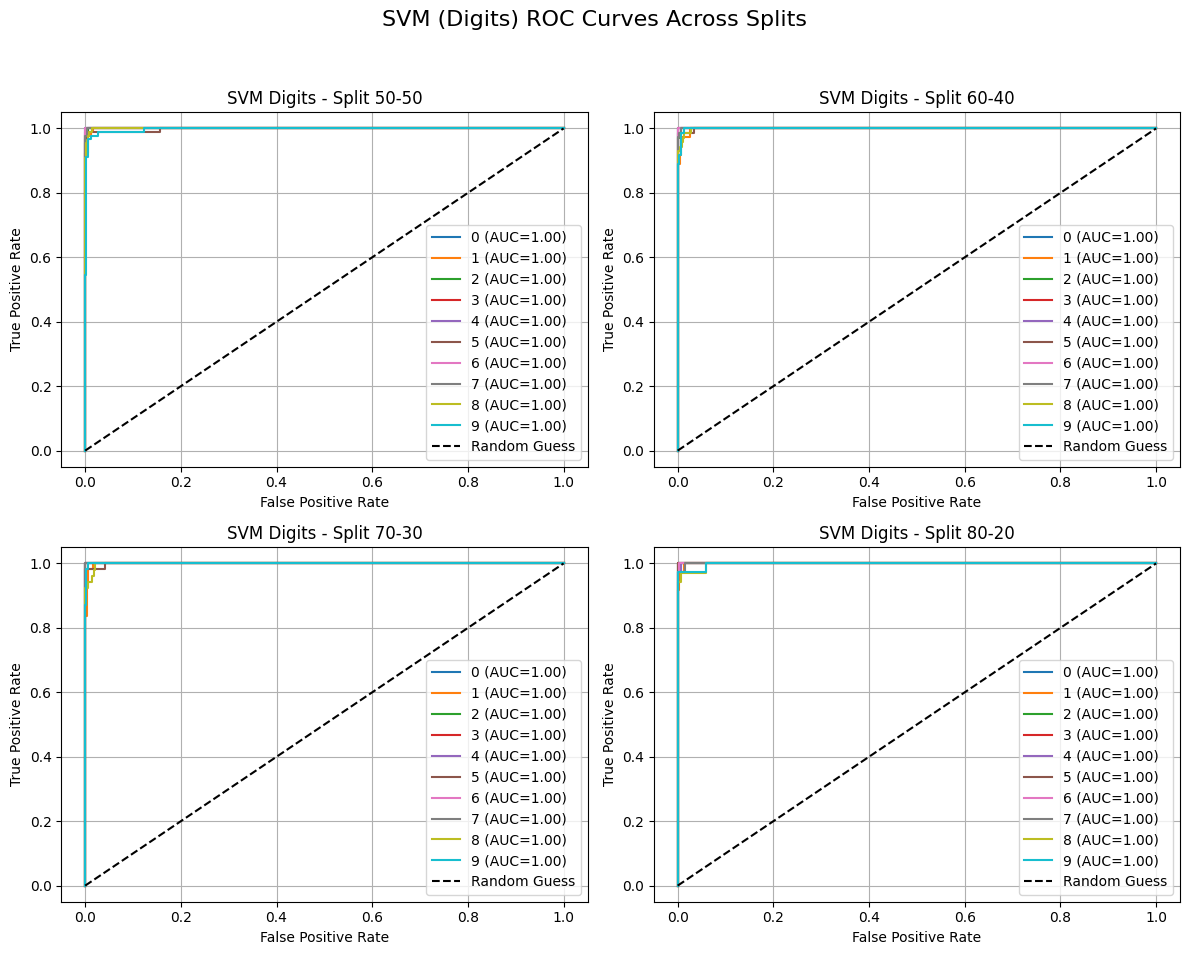

In [43]:
# ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for idx, (label, (fpr, tpr, roc_auc)) in enumerate(roc_collector.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"SVM Digits - Split {label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("SVM (Digits) ROC Curves Across Splits", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

#SVM with PCA=16

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    print(f"\n{model_name} Results:")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    roc_data = None
    if hasattr(model, "predict_proba"):
        y_bin = label_binarize(y_test, classes=np.arange(len(classes)))
        y_score = model.predict_proba(X_test)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        roc_data = (fpr, tpr, roc_auc)

    return acc, prec, rec, f1, roc_data

In [ ]:
svm = SVC(probability=True, random_state=42)
svm_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10],
    "degree": [2, 3],
    "gamma": ["scale", "auto"]
}


 SVM + PCA(16) — Split 50-50
 Best params: {'C': np.float64(10.0), 'degree': np.int64(3), 'gamma': 'scale', 'kernel': 'rbf'}

SVM + PCA16 (50-50) Results:
Accuracy=0.9677, Precision=0.9681, Recall=0.9677, F1=0.9676


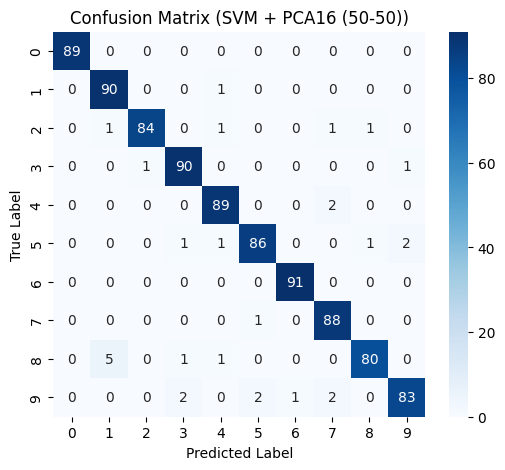


 SVM + PCA(16) — Split 60-40
 Best params: {'C': np.float64(10.0), 'degree': np.int64(3), 'gamma': 'scale', 'kernel': 'rbf'}

SVM + PCA16 (60-40) Results:
Accuracy=0.9708, Precision=0.9714, Recall=0.9708, F1=0.9707


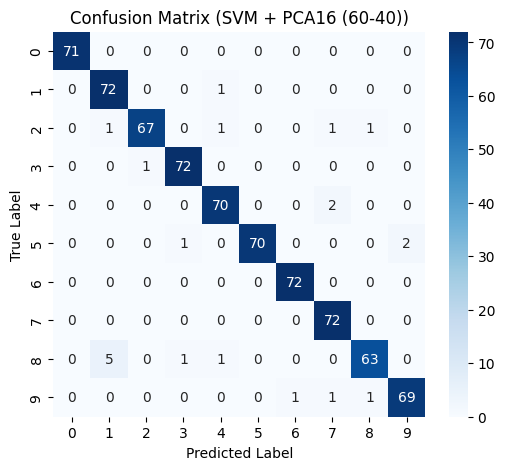


 SVM + PCA(16) — Split 70-30
 Best params: {'C': np.float64(0.1), 'degree': np.int64(2), 'gamma': 'scale', 'kernel': 'linear'}

SVM + PCA16 (70-30) Results:
Accuracy=0.9667, Precision=0.9675, Recall=0.9667, F1=0.9666


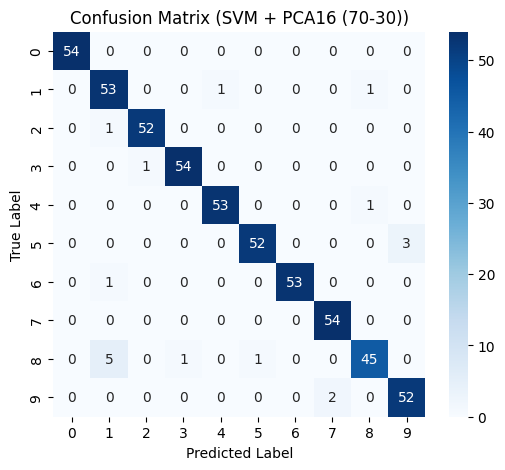


 SVM + PCA(16) — Split 80-20
 Best params: {'C': np.float64(10.0), 'degree': np.int64(3), 'gamma': 'scale', 'kernel': 'rbf'}

SVM + PCA16 (80-20) Results:
Accuracy=0.9639, Precision=0.9657, Recall=0.9639, F1=0.9635


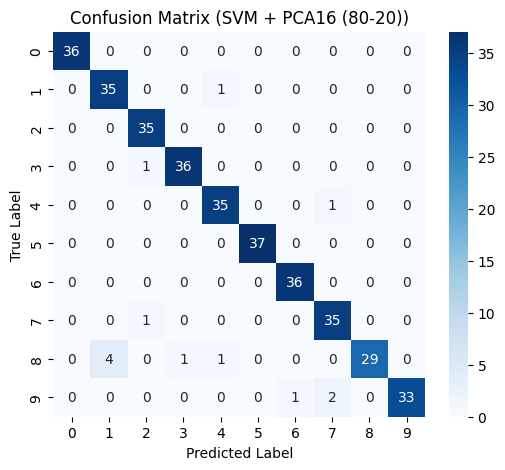

In [ ]:
results_summary = []
roc_collector = {}

for train_size, test_size in splits:
    label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n SVM + PCA(16) — Split {label}\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    pca = PCA(n_components=16, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    grid = HalvingGridSearchCV(svm, svm_params, cv=5, scoring="accuracy",
                               n_jobs=-1, random_state=42, verbose=0)
    grid.fit(X_train_pca, y_train)

    df = pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)
    best = df[df["mean_test_score"] < 1.0].iloc[0] if df.iloc[0]["mean_test_score"] >= 1.0 else df.iloc[0]
    best_params = {k.replace("param_", ""): best[k] for k in df.columns if k.startswith("param_")}
    print(f" Best params: {best_params}")

    best_model = SVC(**best_params, probability=True, random_state=42)
    acc, prec, rec, f1, roc_data = evaluate_model(
        best_model, X_train_pca, X_test_pca, y_train, y_test,
        model_name=f"SVM + PCA16 ({label})"
    )

    results_summary.append([label, acc, prec, rec, f1, ", ".join(f"{k}={v}" for k, v in best_params.items())])
    if roc_data:
        roc_collector[label] = roc_data

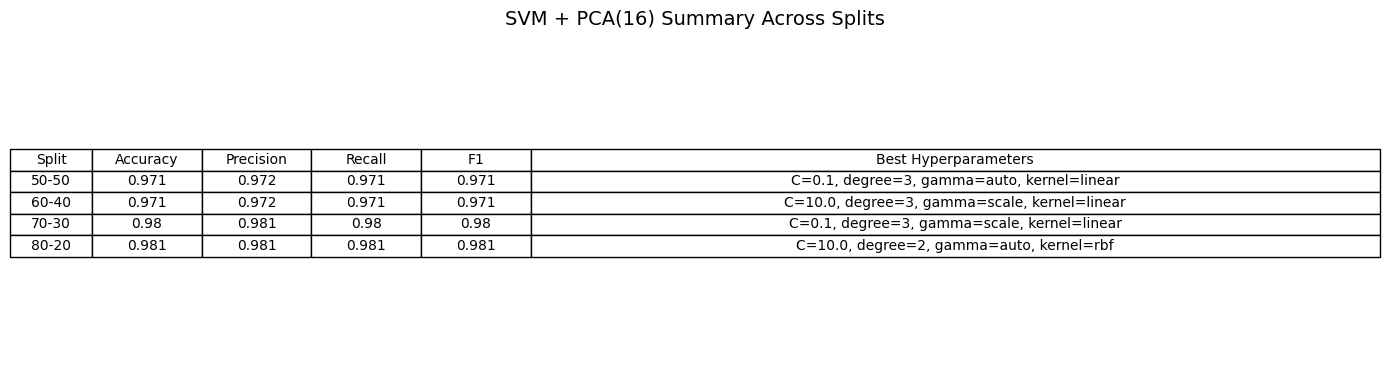

In [44]:
# Summary table
summary_df = pd.DataFrame(results_summary,
                          columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df)*0.7 + 1))
ax.axis("tight"); ax.axis("off")
table = ax.table(cellText=summary_df.round(3).astype(str).values,
                 colLabels=summary_df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for i, w in enumerate(col_widths):
    table[0, i].set_width(w)
    for j in range(1, len(summary_df) + 1):
        table[j, i].set_width(w)

plt.title("SVM + PCA(16) Summary Across Splits", fontsize=14, pad=15)
plt.tight_layout()
plt.show()


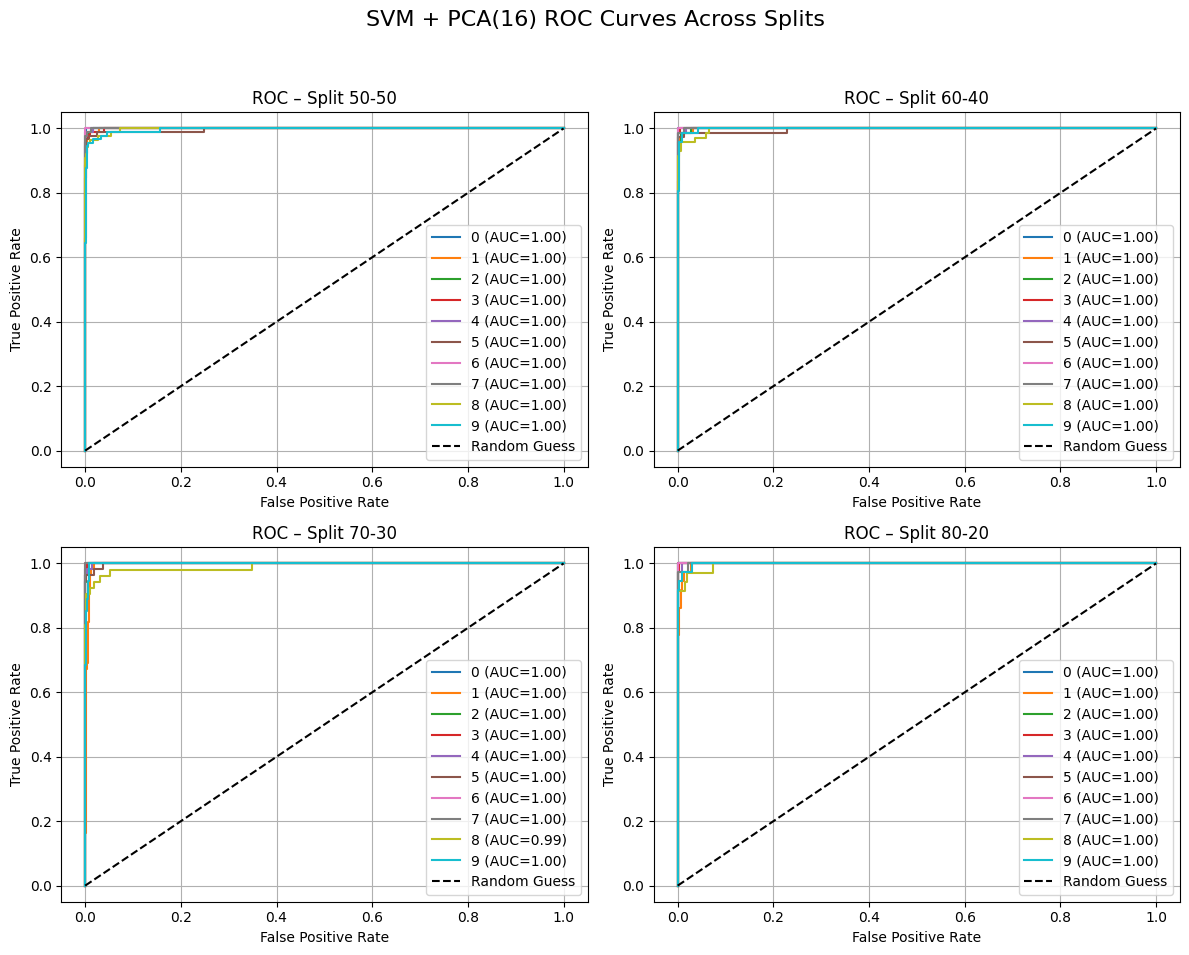

In [ ]:
# ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for idx, (label, (fpr, tpr, roc_auc)) in enumerate(roc_collector.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"ROC – Split {label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("SVM + PCA(16) ROC Curves Across Splits", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

#MLP without PCA

In [45]:
# MLP model and hyperparameter grid
mlp_model = MLPClassifier(random_state=42, max_iter=50)
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate': ['constant', 'adaptive']
}


 MLP on Digits — Split 50-50
Best params: {'activation': 'tanh', 'alpha': np.float64(0.0001), 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

MLP Digits (50-50) Results:
Accuracy=0.9555, Precision=0.9563, Recall=0.9555, F1=0.9555


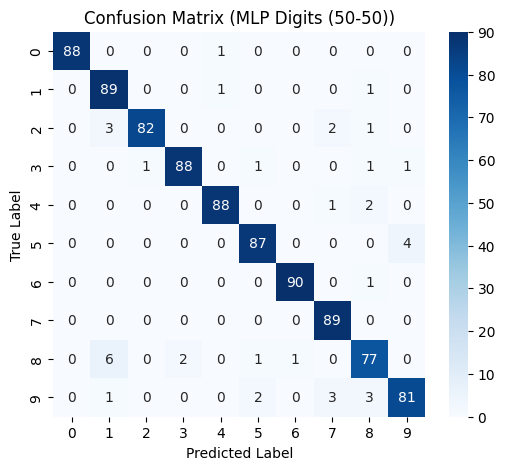


 MLP on Digits — Split 60-40
Best params: {'activation': 'tanh', 'alpha': np.float64(0.01), 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

MLP Digits (60-40) Results:
Accuracy=0.9597, Precision=0.9611, Recall=0.9597, F1=0.9597


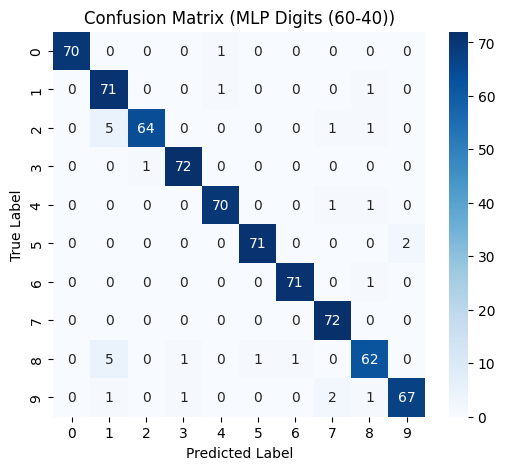


 MLP on Digits — Split 70-30
Best params: {'activation': 'relu', 'alpha': np.float64(0.001), 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

MLP Digits (70-30) Results:
Accuracy=0.9722, Precision=0.9725, Recall=0.9722, F1=0.9722


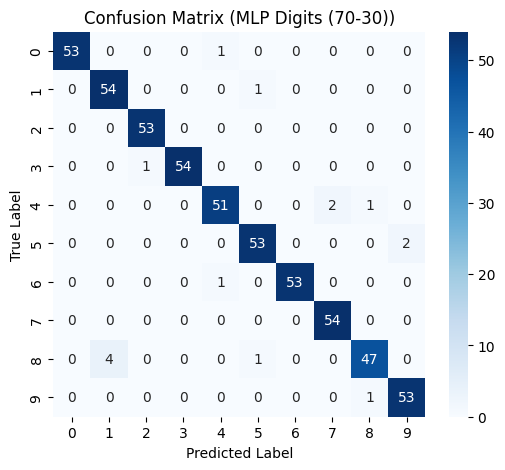


 MLP on Digits — Split 80-20
Best params: {'activation': 'tanh', 'alpha': np.float64(0.001), 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

MLP Digits (80-20) Results:
Accuracy=0.9667, Precision=0.9669, Recall=0.9667, F1=0.9665


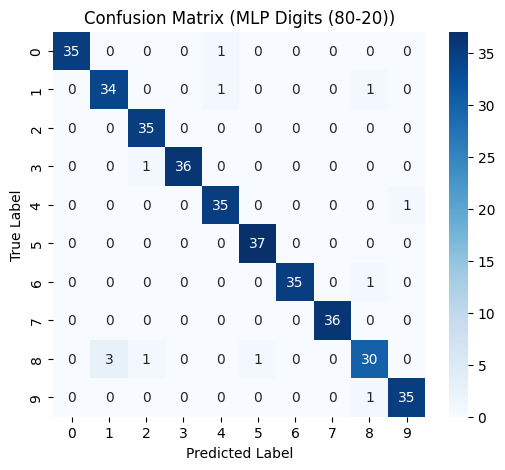

In [46]:
results_summary = []
roc_collector = {}

for train_size, test_size in splits:
    label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n MLP on Digits — Split {label}\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Hyperparameter tuning with HalvingGridSearchCV
    grid = HalvingGridSearchCV(
        mlp_model, mlp_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train, y_train)

    df = pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_score", ascending=False)
    best = df[df["mean_test_score"] < 1.0].iloc[0] if df.iloc[0]["mean_test_score"] >= 1.0 else df.iloc[0]
    best_params = {k.replace("param_", ""): best[k] for k in df.columns if k.startswith("param_")}
    print(f"Best params: {best_params}")

    best_model = MLPClassifier(**best_params, random_state=42, max_iter=50)
    acc, prec, rec, f1, roc_data = evaluate_model(
        best_model, X_train, X_test, y_train, y_test, model_name=f"MLP Digits ({label})"
    )

    results_summary.append([label, acc, prec, rec, f1, ", ".join(f"{k}={v}" for k, v in best_params.items())])
    if roc_data:
        roc_collector[label] = roc_data

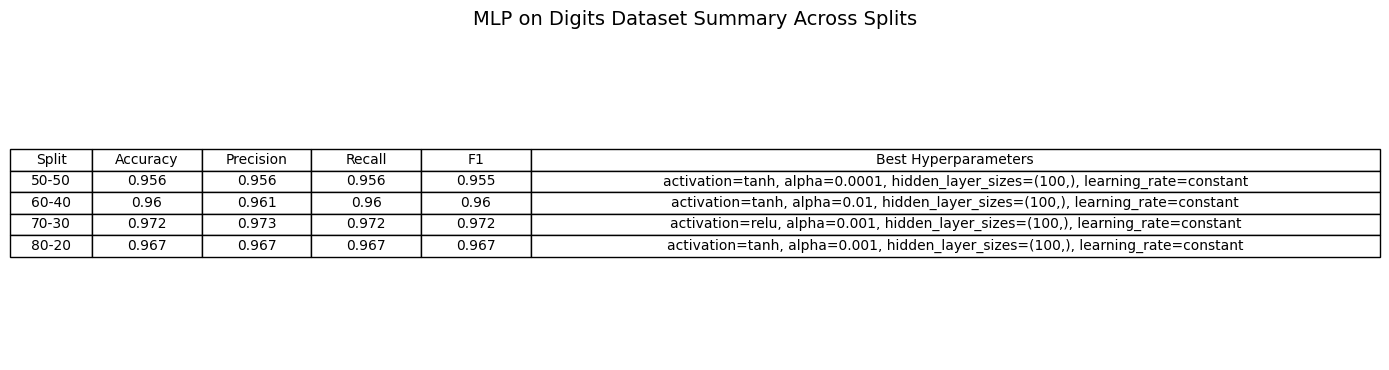

In [47]:
# Summary table
summary_df = pd.DataFrame(results_summary,
                          columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df)*0.7 + 1))
ax.axis("tight")
ax.axis("off")

table = ax.table(cellText=summary_df.round(3).astype(str).values,
                 colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for i, w in enumerate(col_widths):
    table[0, i].set_width(w)
    for j in range(1, len(summary_df)+1):
        table[j, i].set_width(w)

plt.title("MLP on Digits Dataset Summary Across Splits", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

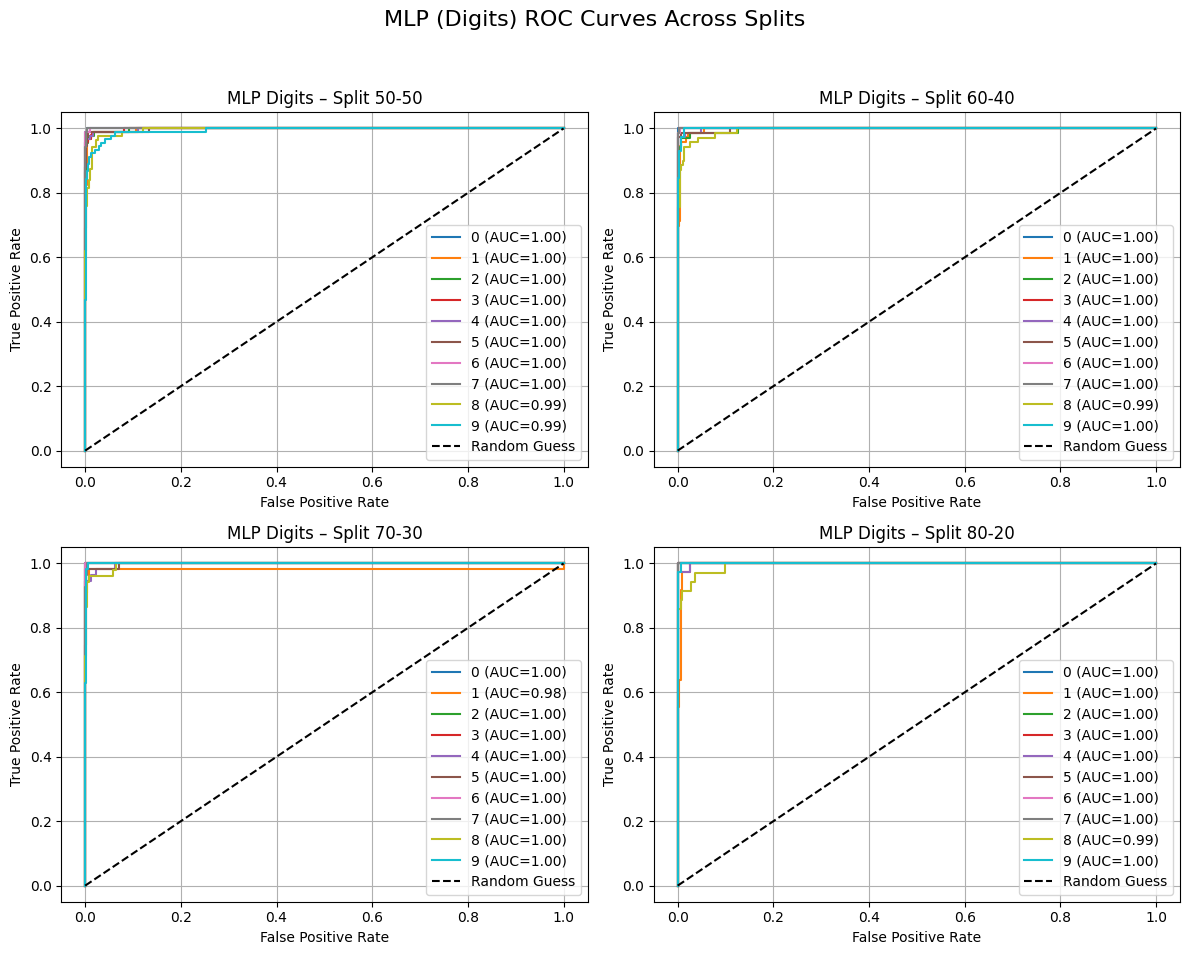

In [48]:
# ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for idx, (label, (fpr, tpr, roc_auc)) in enumerate(roc_collector.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"MLP Digits – Split {label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("MLP (Digits) ROC Curves Across Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#MLP with PCA

In [49]:
# Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    print(f"\n{model_name} Results:")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    roc_data = None
    if hasattr(model, "predict_proba"):
        y_bin = label_binarize(y_test, classes=np.arange(len(classes)))
        y_score = model.predict_proba(X_test)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        roc_data = (fpr, tpr, roc_auc)

    return acc, prec, rec, f1, roc_data


 MLP on Digits with PCA=16 — Split 50-50
Best params: {'activation': 'relu', 'alpha': np.float64(0.0001), 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

MLP Digits PCA16 (50-50) Results:
Accuracy=0.9410, Precision=0.9434, Recall=0.9410, F1=0.9408


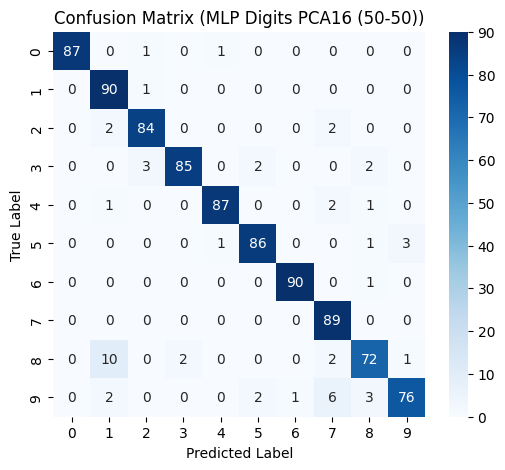


 MLP on Digits with PCA=16 — Split 60-40
Best params: {'activation': 'tanh', 'alpha': np.float64(0.001), 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}

MLP Digits PCA16 (60-40) Results:
Accuracy=0.9527, Precision=0.9539, Recall=0.9527, F1=0.9526


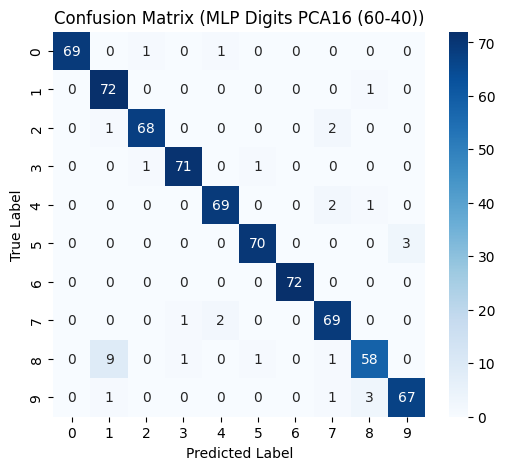


 MLP on Digits with PCA=16 — Split 70-30
Best params: {'activation': 'tanh', 'alpha': np.float64(0.01), 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}

MLP Digits PCA16 (70-30) Results:
Accuracy=0.9574, Precision=0.9587, Recall=0.9574, F1=0.9573


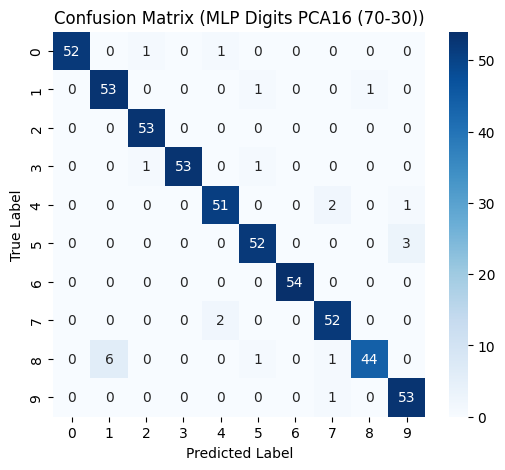


 MLP on Digits with PCA=16 — Split 80-20
Best params: {'activation': 'tanh', 'alpha': np.float64(0.01), 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}

MLP Digits PCA16 (80-20) Results:
Accuracy=0.9472, Precision=0.9508, Recall=0.9472, F1=0.9467


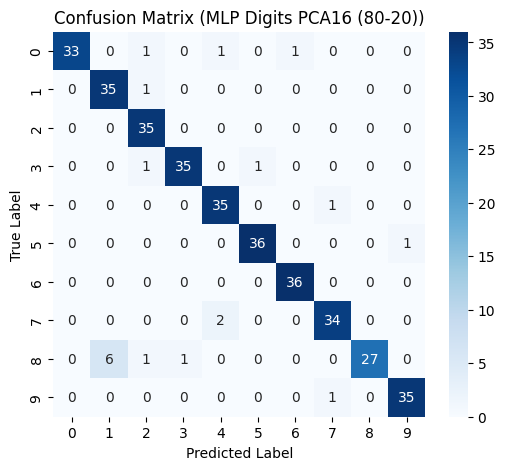

In [50]:
# Results storage
results_summary = []
roc_collector = {}

# PCA config
n_components = 16

# Loop through train-test splits
for train_size, test_size in splits:
    label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n MLP on Digits with PCA=16 — Split {label}\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Hyperparameter tuning
    grid = HalvingGridSearchCV(
        mlp_model, mlp_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train_pca, y_train)

    df = pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_score", ascending=False)
    best = df[df["mean_test_score"] < 1.0].iloc[0] if df.iloc[0]["mean_test_score"] >= 1.0 else df.iloc[0]
    best_params = {k.replace("param_", ""): best[k] for k in df.columns if k.startswith("param_")}
    print(f"Best params: {best_params}")

    best_model = MLPClassifier(**best_params, random_state=42, max_iter=50)
    acc, prec, rec, f1, roc_data = evaluate_model(
        best_model, X_train_pca, X_test_pca, y_train, y_test, model_name=f"MLP Digits PCA16 ({label})"
    )

    results_summary.append([f"{label}", acc, prec, rec, f1,
                            ", ".join(f"{k}={v}" for k, v in best_params.items())])
    if roc_data:
        roc_collector[f"PCA16-{label}"] = roc_data

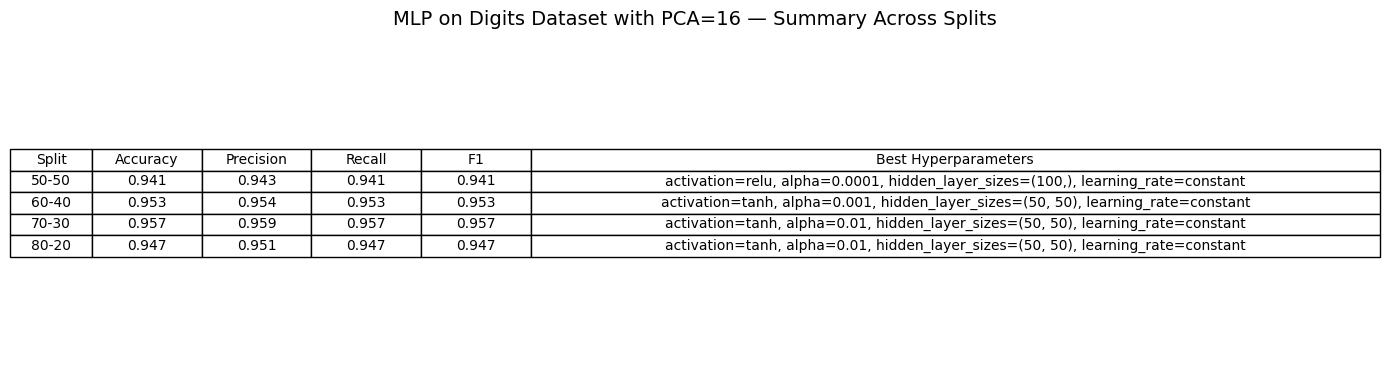

In [51]:
# Summary table
summary_df = pd.DataFrame(results_summary,
                          columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df)*0.7 + 1))
ax.axis("tight")
ax.axis("off")

table = ax.table(cellText=summary_df.round(3).astype(str).values,
                 colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for i, w in enumerate(col_widths):
    table[0, i].set_width(w)
    for j in range(1, len(summary_df)+1):
        table[j, i].set_width(w)

plt.title("MLP on Digits Dataset with PCA=16 — Summary Across Splits", fontsize=14, pad=15)
plt.tight_layout()
plt.show()


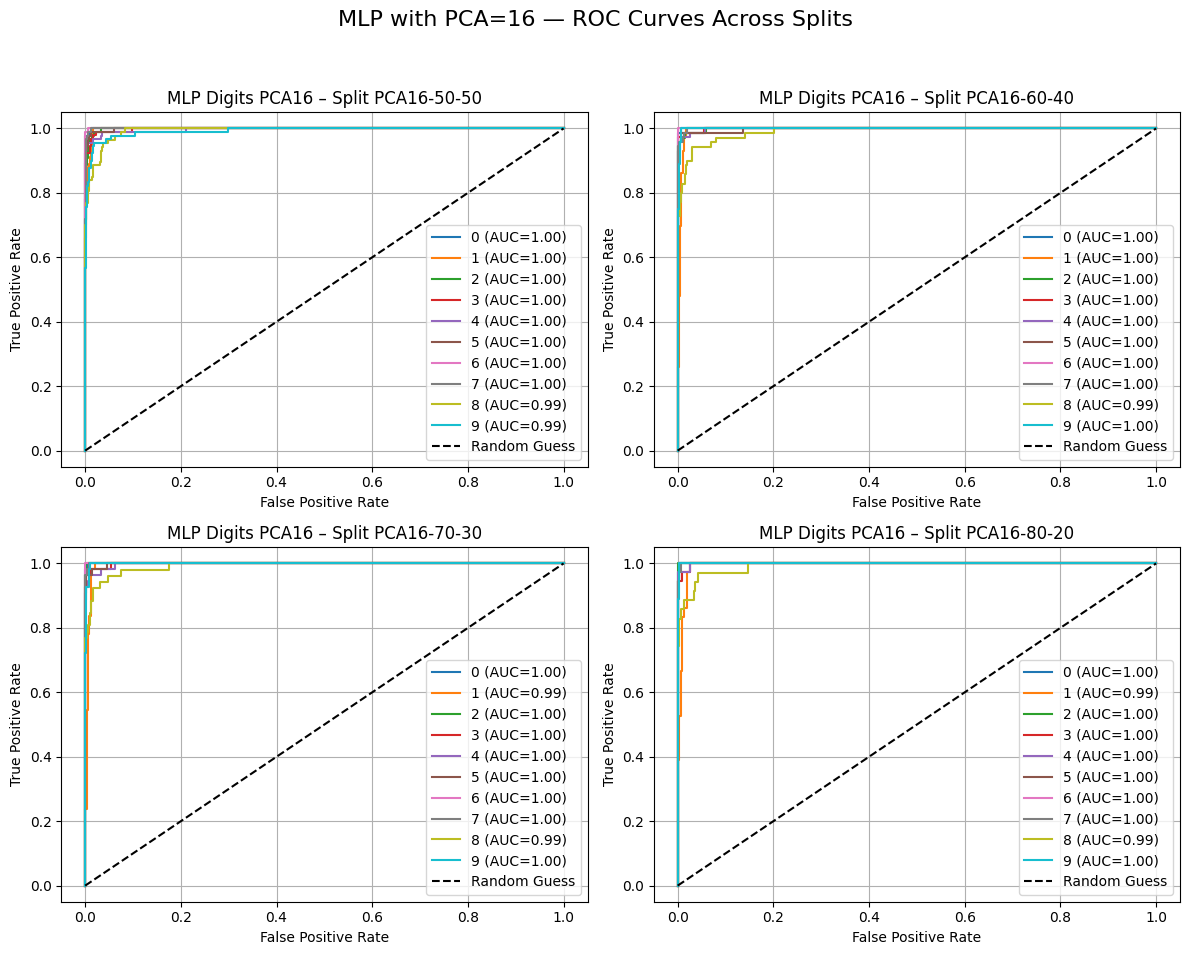

In [52]:
# ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for idx, (label, (fpr, tpr, roc_auc)) in enumerate(roc_collector.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"MLP Digits PCA16 – Split {label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("MLP with PCA=16 — ROC Curves Across Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#RF without PCA

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [10, 15, 30],
    'max_depth': [None, 2, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}


 RF on Digits — Split 50-50
Best params: {'max_depth': None, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(30)}

RF Digits (50-50) Results:
Accuracy=0.9522, Precision=0.9532, Recall=0.9522, F1=0.9521


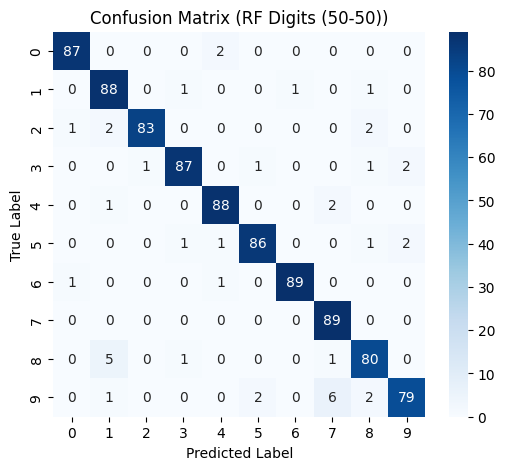


 RF on Digits — Split 60-40
Best params: {'max_depth': None, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(30)}

RF Digits (60-40) Results:
Accuracy=0.9611, Precision=0.9618, Recall=0.9611, F1=0.9607


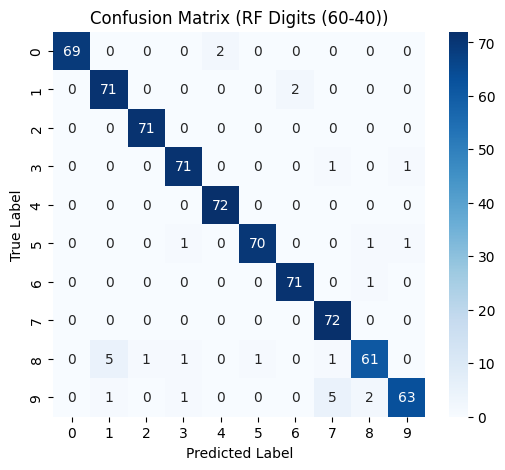


 RF on Digits — Split 70-30
Best params: {'max_depth': None, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(30)}

RF Digits (70-30) Results:
Accuracy=0.9611, Precision=0.9617, Recall=0.9611, F1=0.9611


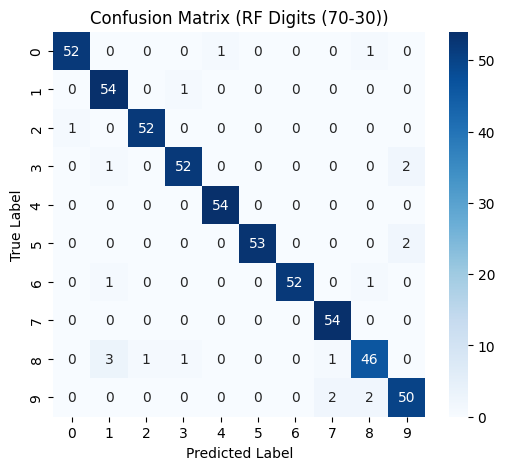


 RF on Digits — Split 80-20
Best params: {'max_depth': None, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(3), 'n_estimators': np.int64(30)}

RF Digits (80-20) Results:
Accuracy=0.9639, Precision=0.9643, Recall=0.9639, F1=0.9637


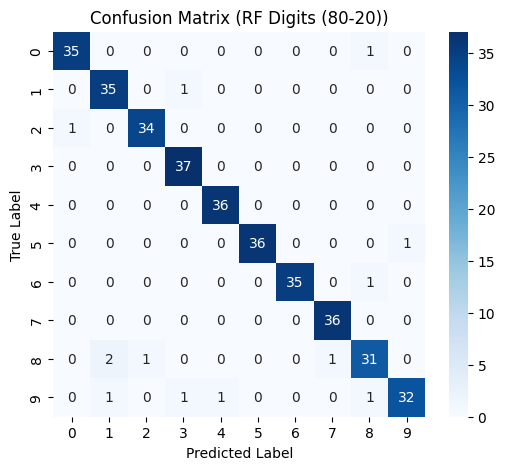

In [54]:
results_summary = []
roc_collector = {}

# Loop through train-test splits
for train_size, test_size in splits:
    label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n RF on Digits — Split {label}\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Hyperparameter tuning
    grid = HalvingGridSearchCV(
        rf_model, rf_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train_scaled, y_train)

    df = pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_score", ascending=False)
    best = df[df["mean_test_score"] < 1.0].iloc[0] if df.iloc[0]["mean_test_score"] >= 1.0 else df.iloc[0]
    best_params = {k.replace("param_", ""): best[k] for k in df.columns if k.startswith("param_")}
    print(f"Best params: {best_params}")

    best_model = RandomForestClassifier(**best_params, random_state=42)
    acc, prec, rec, f1, roc_data = evaluate_model(
        best_model, X_train_scaled, X_test_scaled, y_train, y_test, model_name=f"RF Digits ({label})"
    )

    results_summary.append([label, acc, prec, rec, f1,
                            ", ".join(f"{k}={v}" for k, v in best_params.items())])
    if roc_data:
        roc_collector[label] = roc_data

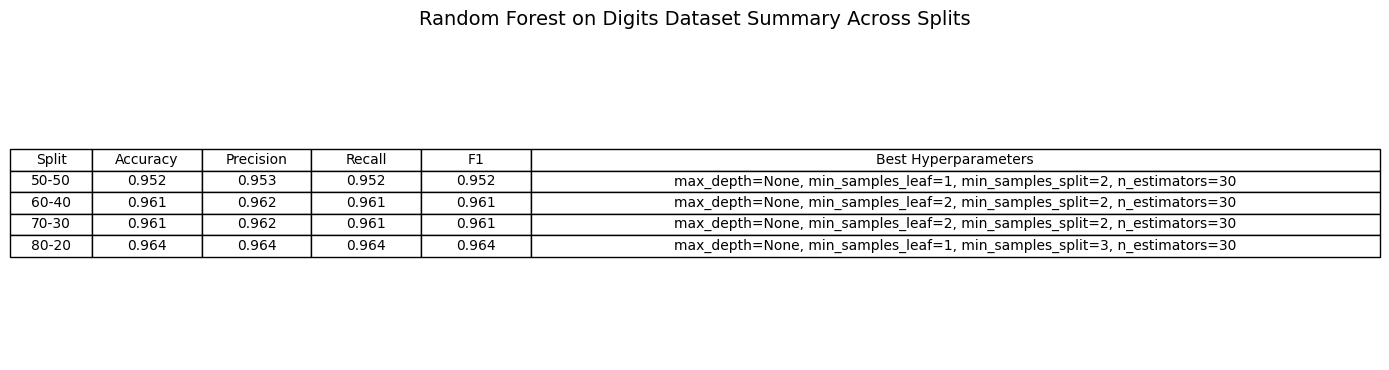

In [55]:

# Summary table
summary_df = pd.DataFrame(results_summary,
                          columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df)*0.7 + 1))
ax.axis("tight")
ax.axis("off")

table = ax.table(cellText=summary_df.round(3).astype(str).values,
                 colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for i, w in enumerate(col_widths):
    table[0, i].set_width(w)
    for j in range(1, len(summary_df)+1):
        table[j, i].set_width(w)

plt.title("Random Forest on Digits Dataset Summary Across Splits", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

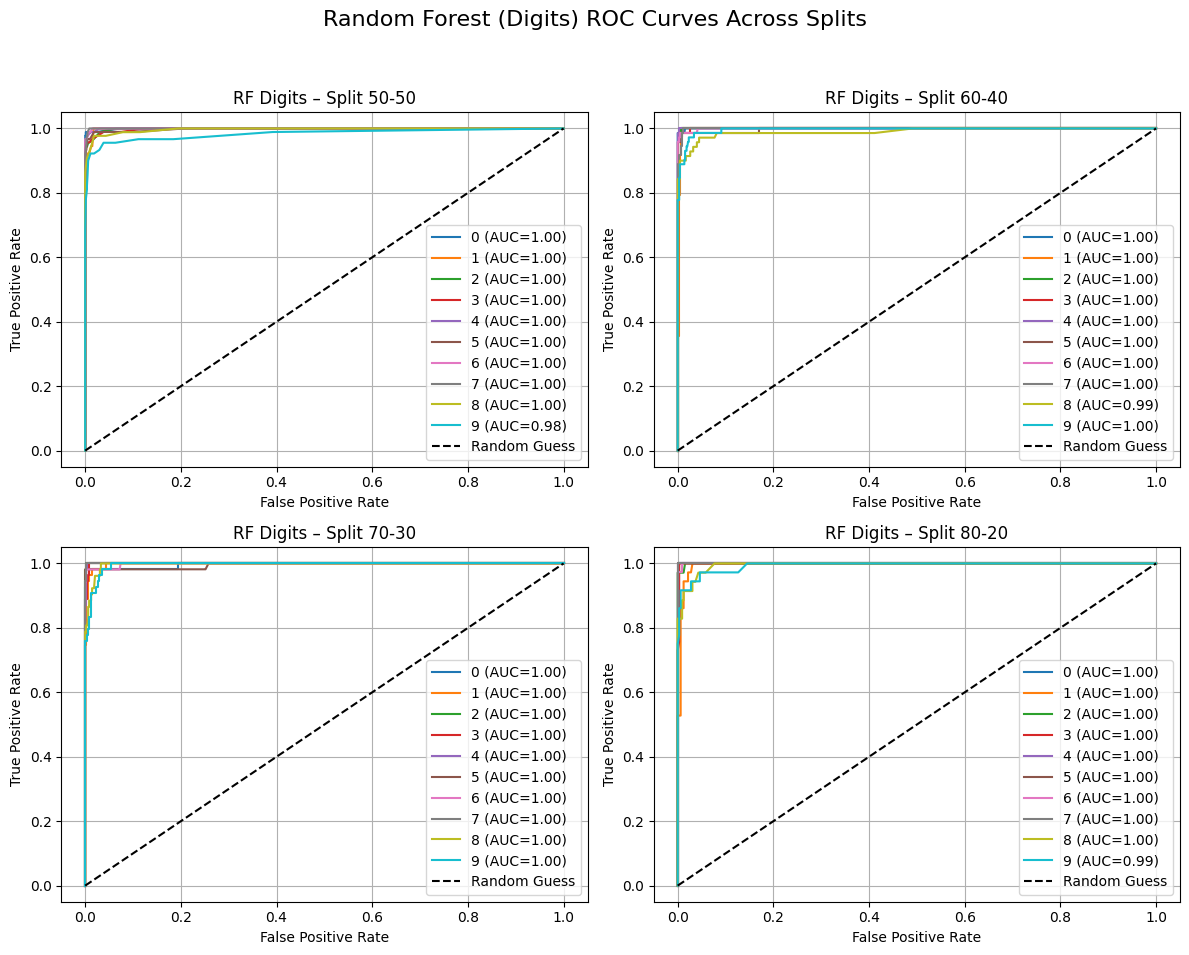

In [56]:
# ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for idx, (label, (fpr, tpr, roc_auc)) in enumerate(roc_collector.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"RF Digits – Split {label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("Random Forest (Digits) ROC Curves Across Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#RF with PCA=16

In [58]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}


 RF with PCA=16 — Split 50-50
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(100)}

RF with PCA=16 (50-50) Results:
Accuracy=0.9355, Precision=0.9371, Recall=0.9355, F1=0.9351


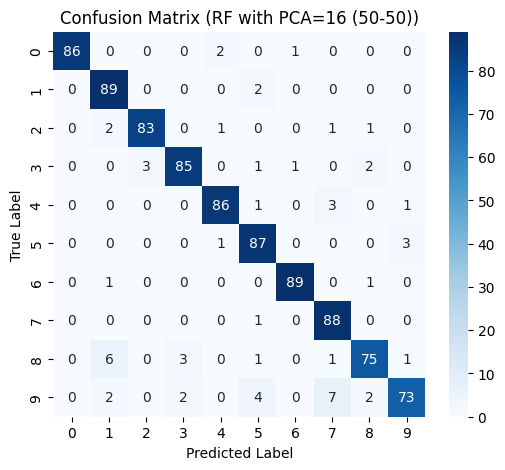


 RF with PCA=16 — Split 60-40
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(100)}

RF with PCA=16 (60-40) Results:
Accuracy=0.9291, Precision=0.9316, Recall=0.9291, F1=0.9290


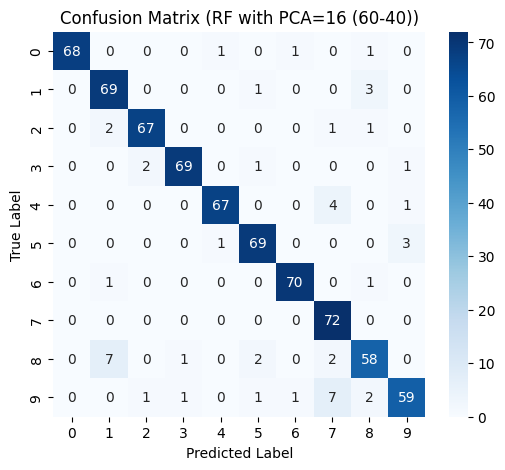


 RF with PCA=16 — Split 70-30
Best params: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(100)}

RF with PCA=16 (70-30) Results:
Accuracy=0.9556, Precision=0.9568, Recall=0.9556, F1=0.9555


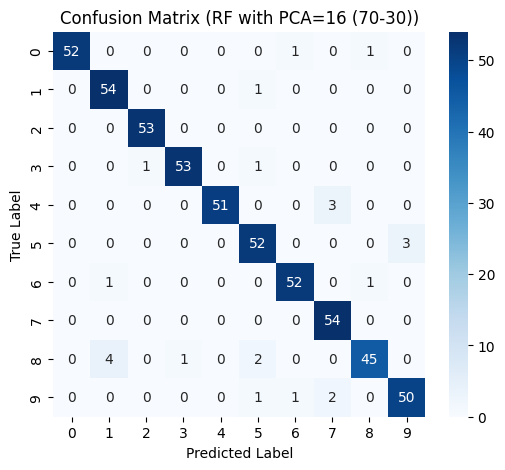


 RF with PCA=16 — Split 80-20
Best params: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(5), 'n_estimators': np.int64(100)}

RF with PCA=16 (80-20) Results:
Accuracy=0.9333, Precision=0.9344, Recall=0.9333, F1=0.9322


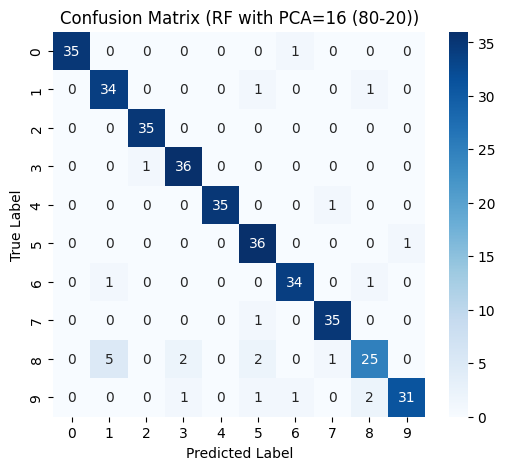

In [59]:
# Results storage
results_summary = []
roc_collector = {}

# Loop through train-test splits
for train_size, test_size in splits:
    label = f"{int(train_size*100)}-{int(test_size*100)}"
    print(f"\n{'='*50}\n RF with PCA=16 — Split {label}\n{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size,
        random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA transform
    pca = PCA(n_components=16, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Hyperparameter tuning
    grid = HalvingGridSearchCV(
        rf_model, rf_params, cv=5, scoring="accuracy",
        n_jobs=-1, random_state=42, verbose=0
    )
    grid.fit(X_train_pca, y_train)

    df = pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_score", ascending=False)
    best = df[df["mean_test_score"] < 1.0].iloc[0] if df.iloc[0]["mean_test_score"] >= 1.0 else df.iloc[0]
    best_params = {k.replace("param_", ""): best[k] for k in df.columns if k.startswith("param_")}
    print(f"Best params: {best_params}")

    best_model = RandomForestClassifier(**best_params, random_state=42)
    acc, prec, rec, f1, roc_data = evaluate_model(
        best_model, X_train_pca, X_test_pca, y_train, y_test, model_name=f"RF with PCA=16 ({label})"
    )

    results_summary.append([label, acc, prec, rec, f1,
                            ", ".join(f"{k}={v}" for k, v in best_params.items())])
    if roc_data:
        roc_collector[label] = roc_data


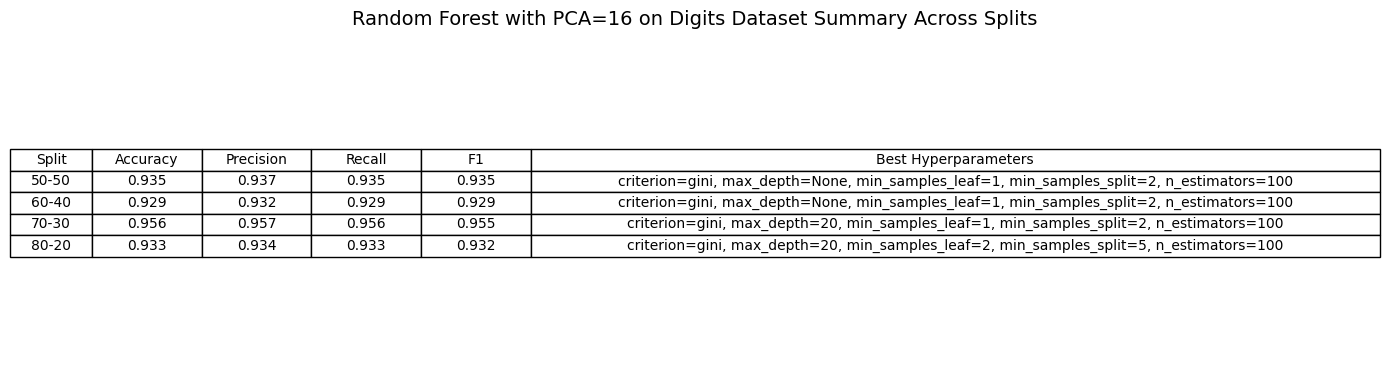

In [60]:
# Summary table
summary_df = pd.DataFrame(results_summary,
                          columns=["Split", "Accuracy", "Precision", "Recall", "F1", "Best Hyperparameters"])

fig, ax = plt.subplots(figsize=(14, len(summary_df)*0.7 + 1))
ax.axis("tight")
ax.axis("off")

table = ax.table(cellText=summary_df.round(3).astype(str).values,
                 colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

col_widths = [0.06, 0.08, 0.08, 0.08, 0.08, 0.62]
for i, w in enumerate(col_widths):
    table[0, i].set_width(w)
    for j in range(1, len(summary_df)+1):
        table[j, i].set_width(w)

plt.title("Random Forest with PCA=16 on Digits Dataset Summary Across Splits", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

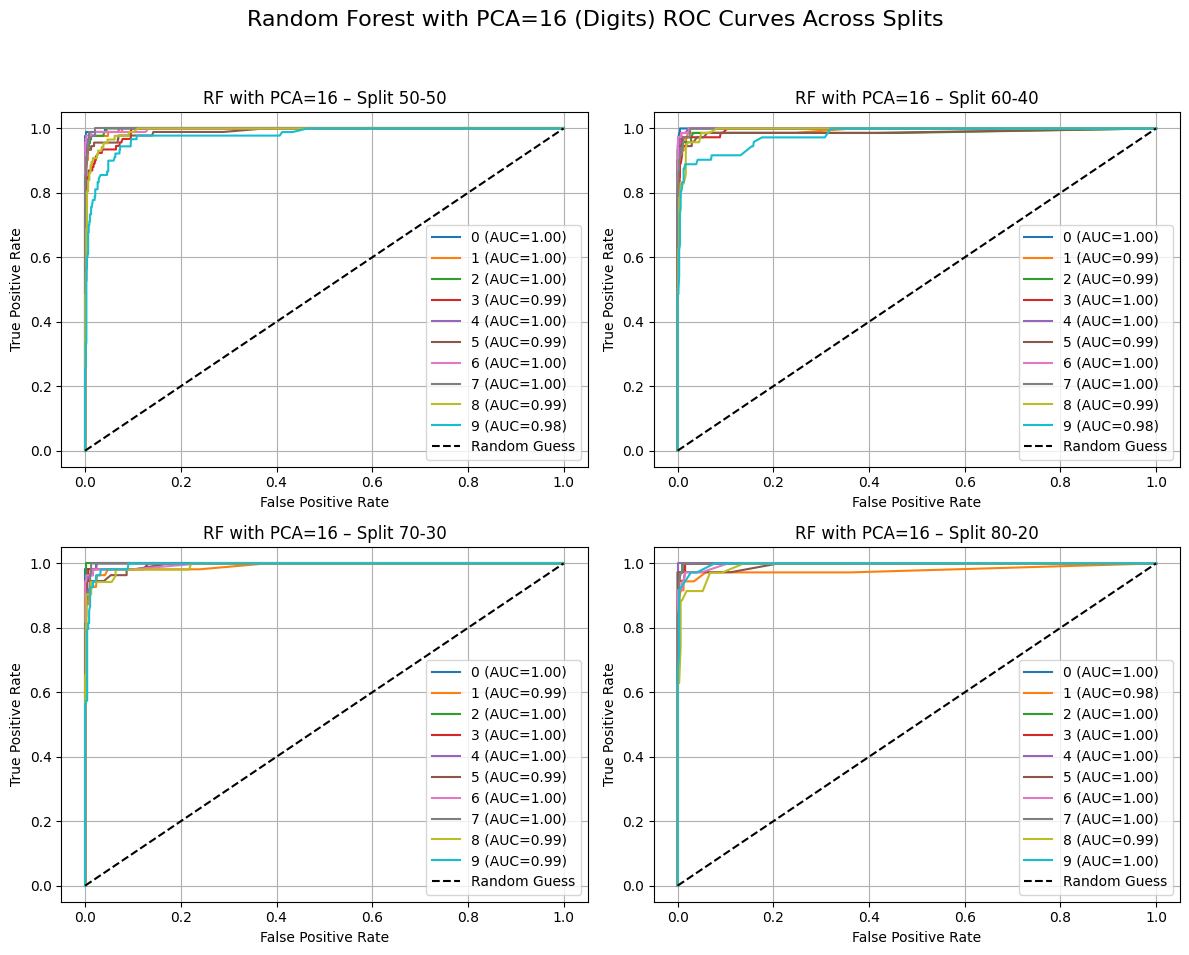

In [ ]:
# ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for idx, (label, (fpr, tpr, roc_auc)) in enumerate(roc_collector.items()):
    ax = axs[idx]
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax.set_title(f"RF with PCA=16 – Split {label}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("Random Forest with PCA=16 (Digits) ROC Curves Across Splits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()